In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from sod.jupyter.utils import * # our user defined functions
# Print a nice doc of the module functions just imported (`printdoc` is defined in `share`)
printdoc()

When using the module share in a Jupyter Notebook, note the following naming
conventions: eval_df denotes an Evaluation Data frame, i.e. a
tabular object where a row is a model evaluation and columns report
evaluation info, e.g., model name, model hyperparams, testset file path,
some evaluation metrics scores. pred_df denotes a Prediction Data frame representing a model evaluation
in details: a row is a testset instance and columns
report several instance info, including the instance actual class as boolean
(column 'outlier') and the predicted class/score as float in [0, 1] (column
'predicted_anomaly_score') Given the above definitions, sod.jupyter.utils imported the following functions/classes/modules that you can use in this Notebook: join Join two or more pathname components, inserting '/' as needed abspath Return an absolute path. dirname Returns the directory component of a pathname isfile Test whether a path is a regular file isdir Return true if the pathname refers to an existing directory. basename Returns the final component of a pathname splitext Split the extension from a pathname expanduser Expand ~ and ~user constructions isabs Test whether a path is absolute sys This module provides access to some objects used or maintained by the os OS routines for NT or Posix depending on what system we're on re Support for regular expressions (RE) time This module provides various functions to manipulate time values inspect Get useful information from live Python objects datetime datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]]) timedelta Difference between two datetime values contextlib Utilities for with-statement contexts Enum Generic enumeration defaultdict defaultdict(default_factory[, ...]) --> dict with default factory namedtuple Returns a new subclass of tuple with named fields np NumPy matplotlib This is an object-oriented plotting library plt `matplotlib.pyplot` is a state-based interface to matplotlib hmean Calculate the harmonic mean along the specified axis metrics The :mod:`sklearn.metrics` module includes score functions, performance metrics dump Persist an arbitrary Python object into one file load Reconstruct a Python object from a file persisted with joblib.dump display Display a Python object in all frontends display_html Display the HTML representation of an object clear_output Clear the output of the current cell receiving output pd pandas - a powerful data analysis and manipulation library for Python cycle cycle(iterable) --> cycle object importlib A pure Python implementation of import. MultipleLocator Set a tick on each integer multiple of a base within the view interval. Segment The Segments table Station Stations g_s Create and returns an sql alchemy session for IO db operations aiming to yaml get_session with get_session(dbname_or_dbid) as session: printhtml Same as display_html(text, True): prints the html formatted text
passed as argument EVALMETRICS Evaluation metrics enumeration. Each enum item is mapped to a string:
 AUC = 'roc_auc_score'
 APS = 'average_precision_score'
 LOGLOSS = 'log_loss'
 F1MAX = 'f1_max' (F1score at BEST_TH_PR )
 PMAX = 'p_max' (Precision at BEST_TH_PR )
 RMAX = 'r_max' (Recall at BEST_TH_PR )
 BEST_TH_PR 
 and has a compute method
(e.g., EVALMETRICS.APS.compute(pred_df) ) which
returns the metric scalar value from a prediction dataframe read_summary_eval_df read_summary_eval_df(**kwargs) = pandas
 read_hdf('../evaluations/results/summary_evaluationmetrics.hdf', **kwargs) 
reads and returns the Evaluation dataframe created and incremented by each
execution of the main script evaluate.py . *Thus, if no
evaluation has been run on this computer, no evaluation dataframe exists
and the Notebook using this module will not work.*
Keyword arguments of the functions are the same keyword arguments as pandas
 read_hdf . read_eval_df load_clf load_clf(relativepath) loads a classifier from a path relative to
the evaluation directory of this package (where e

In [2]:
printhtml('<h3>Defining notebook variables</h3>')

# matplotlib stuff. Note that rcParams need to be input from the second cell on
# (https://github.com/jupyter/notebook/issues/3385#issuecomment-376010658)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# for font size details, see https://stackoverflow.com/a/39566040
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = plt.rcParams['font.size']
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'helvetica,arial'

# pandas settings. Some are set in `share`, display max_rows is explicitly set here
pd.set_option('display.max_rows', 25)

TRAINSET = 'allset_train.hdf'
TRAINSET_U = 'uniform_train.hdf'
TESTSETNAME1 = 'allset_test.hdf'
TESTSETNAME2 = 'allset_unlabelled_annotation2.hdf'
TESTSETNAME_12 = 'allset_test_AND_allset_unlabelled_annotation2.hdf'
TESTSETNAME_UNLABELLED = 'allset_unlabelled.hdf'
TESTSETNAME_U = 'uniform_test.hdf'
TESTSETNAME_U_1 = 'uniform_test_dataset1.hdf'

SAVE_FIGURES = False  # set to False to disable figures in the function below

# columns to display for an Evaluation dataframe:
EVALDF_DISPLAYCOLUMNS = ['clf', 'feats', 'n_estimators', 'max_samples', 'random_state', 'average_precision_score',
                         'best_th_pr_curve', 'roc_auc_score', 'log_loss', 'relative_filepath',
                         # these are useless to show. The first is an experimental metric,
                         # the other three are parameters always equal for all models:
                         # 'best_th_roc_curve', 'behaviour', 'contamination',  'tr_set'
                        ]


from sod.core.paths import DATASETS_DIR

def savefig(fig, name):
    '''Save a figure for the paper in a dedicated folder'''
    if not SAVE_FIGURES:
        print('(SAVE_FIGURES=False)')
        return
    root = os.path.expanduser('~')
    outpath = abspath(join(root, 'Nextcloud', 'rizac', 'outliers_paper', 'paper_figures'))
    assert isdir(outpath)
    outpath = join(outpath, name + '.png')
    printhtml('Saving figure to "~/%s"' % os.path.relpath(abspath(outpath), root))
    fig.savefig(outpath, dpi=plt.rcParams['figure.dpi'], format='png')
    # join(dirname(dirname(dirname(os.getcwd())))

import yaml
from stream2segment.process.db import get_session, Segment, Station, Event, loads_inv, Base 

def get_db_session(dataset_id):
    '''returns an SQLAlchemy session from the given dataset_id (1: europe, 2: me, 3: chile)'''
    keys = [None, 'dbpath_eu_new', 'dbpath_me', 'dbpath_chile']
    with open(join(os.getcwd(), 'jnconfig.yaml')) as _:
        dburl = yaml.safe_load(_)[keys[dataset_id]]
    # Use stream2segment API, which also loads the Segment obspy capabilities (Segmetn)
    return get_session(dburl)
    # Or load session with the SQLAlchemy lower level API:
#     from sqlalchemy import create_engine
#     engine = create_engine(dburl, connect_args={'connect_timeout': 10})  # 
#     Base.metadata.create_all(engine)  # @UndefinedVariable
#     from sqlalchemy.orm.session import sessionmaker
#     return sessionmaker(bind=engine)()

from obspy.signal.spectral_estimation import PPSD

def ppsd(raw_trace, inventory, periods=None):
    '''Returns the arrays
        periods, amplitudes_db
    Where amplitudes are the computed PSD (power spectral density)
    if the argument `periods` is not None but an array or scalar (in seconds), returns:
        periods, amplitudes_db_interpolated_on_periods
    '''
    try:
        # ppsd_ = psd(raw_trace, inventory)
        dt = raw_trace.stats.endtime - raw_trace.stats.starttime  # total_seconds
        ppsd_ = PPSD(raw_trace.stats, metadata=inventory, ppsd_length=int(dt))
        ppsd_.add(raw_trace)
    except Exception as esc:
        raise ValueError('%s error when computing PSD: %s' %
                         (esc.__class__.__name__, str(esc)))
    # check first if we can interpolate ESPECIALLY TO SUPPRESS A WEIRD
    # PRINTOUT (numpy?): something like '5064 5062' which happens
    # on IndexError (len(ppsd_.psd_values)=0)
    if not len(ppsd_.psd_values):
        raise ValueError('Expected 1 psd array, no psd computed')
    x, y = ppsd_.period_bin_centers, ppsd_.psd_values[0]
    if periods is None:
        return x, y
    periods = np.asarray(periods)
    newy = np.interp(np.log10(periods), np.log10(x), y)
    if np.ndim(newy) > 0:
        newy[periods < x[0]] = np.nan
        newy[periods > x[-1]] = np.nan
    return x, newy


def magdist(dataframe, ceil=None):
    colx, coly = 'distance_km', 'magnitude'
    # CEIL = 5000
    # printhtml(f'<h4>Training segment distribution (signal parts ognly) with ceiling at {CEIL} segments per cell</h4>')
    dfr = heatmap_df(dataframe, colx, coly,
                         np.arange(0, 12000, 1000), np.arange(0.5, 9.5, 0.5))

    if ceil:
        dfr[dfr > ceil] = ceil
    print(f'{dfr.sum().sum():,d} instances')
    display(dfr.iloc[::-1])

    # Index= ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
    # Cols = ['A', 'B', 'C', 'D']
    # df = DataFrame(abs(np.random.randn(5, 4)), index=Index, columns=Cols)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.rcParams['font.size'] = 12

    plt.pcolor(dfr, cmap='hot_r')
    plt.yticks(np.arange(0.5, len(dfr.index), 1), dfr.index)
    plt.xticks(np.arange(0.5, len(dfr.columns), 1), dfr.columns)
    plt.ylabel(coly)
    plt.xlabel(colx)
    plt.xticks(rotation=80)
    # plt.grid()
    plt.show()
    return dfr



def plot_prediction_per_maxsamples(pred_dfs):
    
    from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                   AutoMinorLocator)

    # printhtml('<h3>Summary plots n_estimators=200 only (and random_state=11)</h3>')

    PETTERSON_PERIOD = 5  # set to 0 to ignore

    rows, cols = len(pred_dfs), 4
    # rows, cols = 2*len(pred_dfs), 3
    fig = plt.figure(constrained_layout=True)
    gsp = fig.add_gridspec(rows, cols, width_ratios=[1,10, 10, 10])
    # gsp = fig.add_gridspec(rows, cols, height_ratios=[1,15] * len(pred_dfs))
    colors = get_colors(len(pd.unique([_.max_samples for _ in pred_dfs.keys()])))
    psdperiods = np.arange(-230, 0, 0.1)

    # axs_all = [[], [], []]
    for idx, (rowtuple, pred_df) in enumerate(pred_dfs.items()):
        title= "(max_s=%s)" % (rowtuple.max_samples)

        aps, p, r, th, f = EVALMETRICS.computeall(pred_df, EVALMETRICS.APS,
                                                  EVALMETRICS.PMAX, EVALMETRICS.RMAX,
                                                  EVALMETRICS.BEST_TH_PR, EVALMETRICS.F1MAX)

        axs = fig.add_subplot(gsp[idx, 1])
        mp_hist_kw = {
            'color': ['white', colors[idx]],
            'edgecolor':colors[idx],
            'histtype': 'stepfilled', 'stacked': True,
            'linewidth': 2
        }
        axs = plot_freq_distribution(pred_df, axs, title='', mp_hist_kwargs=mp_hist_kw)
        axs.set_xticks([0.5, np.round(th, 2)])
        axs.tick_params(which='major', length=7)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 2])
        axs = plot_pre_rec_fscore(pred_df, axs, title='', mp_plot_kwargs={'color': colors[idx]})
        axs.tick_params(which='major', length=7)
        # bbox_to_anchor: A 2-tuple (x, y) places the corner of the legend specified by `loc` at x, y. 
        lgnd = axs.legend(loc='lower center', bbox_to_anchor=(0.5, 0))
        axs.set_ylim(-0.2, 1.02)
        axs.set_axisbelow(True)

        axs = fig.add_subplot(gsp[idx, 3])
        try:
            clf = load_clf(dirname(rowtuple.relative_filepath) + '.sklmodel')
            scores = -clf.score_samples(psdperiods.reshape(len(psdperiods), 1))
            # plot scores:
            axs.plot(psdperiods, scores, color=colors[idx], linewidth=2)
            # plot petterson:
            pbounds = get_petterson_bounds(PETTERSON_PERIOD)
            axs.axvline(pbounds[0], linestyle=':', linewidth=2)
            axs.axvline(pbounds[1], linestyle=':', linewidth=2)
            # plot shaded areas between 0.5 and score optimizing f1score:
            indices1 = argwhere_array_equals_value(scores, th)
            indices2 = argwhere_array_equals_value(scores, 0.5)
            psd_l = psdperiods[indices1[0]], psdperiods[indices2[0]]
            axs.axvspan(psd_l[0], psd_l[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
            psd_h = psdperiods[indices2[-1]], psdperiods[indices1[-1]]
            axs.axvspan(psd_h[0], psd_h[1], alpha=0.2, linestyle='--', linewidth=0, color=colors[idx])
            axs.grid()
            # displaying bounds:
            bound1 = str([int(psd_l[0]+0.5), int(psd_l[1]+0.5)])
            bound2 = str([int(psd_h[0]+0.5), int(psd_h[1]+0.5)])
            w1 = float(psd_l[1] - psd_l[0])
            w2 = float(psd_h[1] - psd_h[0])
            axs.text(psd_l[1] - w1/2.0, min(scores), bound1, ha='right', va='bottom', backgroundcolor=[1,1,1,0.5])
            axs.text(psd_h[0] + w2/2.0, min(scores), bound2, ha='left', va='bottom', backgroundcolor=[1,1,1,0.5])
            # set axis ticks:
            axs.xaxis.set_minor_locator(MultipleLocator(25))
            axs.yaxis.set_minor_locator(MultipleLocator(0.1))
            axs.grid(axis="both", which='minor', linestyle='-')
            axs.set_yticks([0.5, np.round(th, 2)])
            axs.tick_params(which='major', length=7)
            axs.set_xlabel('psd(5) (dB)')
            axs.set_ylabel('score')
            axs.set_axisbelow(True)
        except Exception as exc:
            from textwrap import wrap
            axs.text(0, 0, "\n".join(wrap(str(exc), width=20)))
        
        # summary in the leftmost plot:
        # plot it as last so we have all data avilable
        axs = fig.add_subplot(gsp[idx, 0])
        text = f'$\psi$: {rowtuple.max_samples:>5d}\nAPS: {aps:.3f}' # % (rowtuple.max_samples, aps)
        axs.text(0.5, 1, text, ha='right', va='top', rotation=0, linespacing=2, family='monospace') 
        axs.set_axis_off()

    return fig


print('done')

Defining notebook variables

done


In [3]:
printhtml('<h3>Loading evaluation dataframe</h3>')
eval_df = read_eval_df('evaluationmetrics.hdf') #  read_summary_eval_df()
print('Done')

Loading evaluation dataframe

Done


In [5]:
setname = TESTSETNAME_U
n_est = 100
feats = 'psd@5sec'

for n_est in (50, 100):
    printhtml(f'<h3>Performances on {setname}, features={feats}, n_estimators={n_est}</h3>')


    # printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
    #           'average precision score</h3>')

    eval_df2 = []
    for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                          (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
            groupby(['n_estimators', 'max_samples']):
        _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
        assert len(_df) == 1
        eval_df2.append(_df)
    eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

    pd.set_option('display.max_rows', 500)

    display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

    printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
    pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score',
                                               'channel_code',
                                               'station_id', 'Segment.db.id', 'outlier',
                                               'location_code', 'window_type', 'dataset_id', 'magnitude'])

    from collections import defaultdict
    metricname = 'average_precision_score'


    hls = read_handlabelled_segments()

    misclcount = []

    for did in [1, 2, 3, 4]:
        for wtype in (True, False):
            wtype_str = 'SIGNAL' if wtype else 'NOISE'
            print()
            print()
            # printhtml(f'<h4>Performances on {setname}, features={feats}, n_estimators={n_est}</h4>')
            printhtml(f'<h4>Performances on {wtype_str} windows only, dataset_id={did}</h4>')
            partial_eval = defaultdict(list)
            miscl_outl = defaultdict(list)
            miscldf = None
            for k, (tupl, p) in enumerate(pred_dfs.items()):
                _p = p[(p.dataset_id == did) & (p.window_type == wtype)]

                # caluclate misclassified outliers:
                _m = _p
                _m = _m[_m.outlier & (_m.predicted_anomaly_score < tupl.best_th_pr_curve)].copy()
                misclcount.append(len(_m))
                _m['_KEY'] = (_m.station_id).astype('str').str.cat(_m.location_code, sep='.').str.cat(_m.channel_code.str[:-1], sep='.') + '?'
                for key, _df in _m.groupby('_KEY'):
                    miscl_outl[key].append(len(_df))

                # calculate metric on partial evaluation set:
                aps = EVALMETRICS.APS.compute(_p)
                partial_eval[metricname] += [aps]
                for fld in tupl._fields:
                    if fld != metricname:
                        partial_eval[fld] += [getattr(tupl, fld)]

            # display new evaluation dataframe (partial set):
            display(pd.DataFrame(partial_eval).sort_values([metricname], ascending=False)[EVALDF_DISPLAYCOLUMNS])

            # display misclassified oiutliers and stations of interest:
            _dic = {k: np.mean(v) for k, v in miscl_outl.items() if len(v) == len(pred_dfs)}
            _dic = pd.DataFrame(_dic.values(), columns=['MOs (average count)'], index=_dic.keys()).\
                sort_values(['MOs (average count)'], ascending=False)
            _n = 5
            printhtml(f'We have an average of {np.mean(misclcount):,.2f} misclassified outliers (MO) per model '
                  f'(MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the {_n} "most wrong" channels (ignoring orientation):')
            # printhtml(f'Details grouping by channels (ignoring orientation) and showing first {_n} only')
            _dicprint = _dic.head(_n)
            _dicprint = _dicprint.append(_dicprint.sum(numeric_only=True).rename('Total'))
            display(_dicprint)


    #print()
    #printhtml(f'<h3>Details on feats={miscltup.feats}, n_estimators={miscltup.n_estimators}, max_samples={miscltup.max_samples}, random_state={miscltup.random_state}</h3>')
    #printhtml(f'<h4>{len(miscldf)} of {misclcount} outliers ar "kind of" misclassified, i.e. have scores < {miscltup.best_th_pr_curve}</h4>')
    #print('Unique segment ids (whihc have both noise and signal misclassified):')
    #miscldf = miscldf.sort_values('predicted_anomaly_score', ascending=True)
    #display(" ".join(str(_[1]['Segment.db.id'].iloc[0]) for _ in miscldf.groupby('Segment.db.id', sort=False) if len(_[1]) == 2))
    #print()
    #print('Dataframe:')
    #display(miscldf)

    # for _ in eval_df.itertuples():
    #     pred_df = get_pred_df
    # display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on uniform_test.hdf, features=psd@5sec, n_estimators=50

clf     feats  n_estimators  max_samples  random_state  \
1599  IsolationForest  psd@5sec            50         2048            11   
1595  IsolationForest  psd@5sec            50         1024            25   
1606  IsolationForest  psd@5sec            50          512            11   
1601  IsolationForest  psd@5sec            50         4096            11   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1599                 0.970213          0.737760       0.975100  0.559445   
1595                 0.969853          0.739561       0.975201  0.574039   
1606                 0.968845          0.745870       0.975527  0.605512   
1601                 0.968842          0.668166       0.973910  0.556683   

                                                                                                                                                   relative_filepath  
1599  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1595  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
1606   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1601  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on SIGNAL windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
2  IsolationForest  psd@5sec            50         2048            11   
1  IsolationForest  psd@5sec            50         1024            25   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.895322          0.745870       0.975527  0.605512   
2                 0.884585          0.737760       0.975100  0.559445   
1                 0.883995          0.739561       0.975201  0.574039   
3                 0.875973          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 10,925.00 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              2265.75
7744..HH?              1645.25
7704..HH?              1539.75
5600..HN?              1455.50
7673..HH?               838.00
Total                  7744.25

Performances on NOISE windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
2  IsolationForest  psd@5sec            50         2048            11   
1  IsolationForest  psd@5sec            50         1024            25   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.885596          0.745870       0.975527  0.605512   
2                 0.874070          0.737760       0.975100  0.559445   
1                 0.872897          0.739561       0.975201  0.574039   
3                 0.868633          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 10,709.75 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              1856.25
7744..HH?              1628.25
7704..HH?              1527.50
5600..HN?              1453.00
7673..HH?               858.00
Total                  7323.00

Performances on SIGNAL windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
3  IsolationForest  psd@5sec            50         4096            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
0  IsolationForest  psd@5sec            50          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
3                 0.987935          0.668166       0.973910  0.556683   
1                 0.987871          0.739561       0.975201  0.574039   
2                 0.987742          0.737760       0.975100  0.559445   
0                 0.983975          0.745870       0.975527  0.605512   

                                                                                                                                                relative_filepath  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 9,955.92 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3507..BH?               785.00
2861..BH?               582.25
2863..BH?               480.00
2772..BH?               420.75
10..BH?                 225.00
Total                  2493.00

Performances on NOISE windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.994345          0.745870       0.975527  0.605512   
1                 0.994297          0.739561       0.975201  0.574039   
2                 0.994252          0.737760       0.975100  0.559445   
3                 0.993947          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 8,518.38 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
2772..BH?               954.75
3507..BH?               785.00
2861..BH?               625.50
2863..BH?               493.00
10..BH?                 244.75
Total                  3103.00

Performances on SIGNAL windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.745870       0.975527  0.605512   
1                      NaN          0.739561       0.975201  0.574039   
2                      NaN          0.737760       0.975100  0.559445   
3                      NaN          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 6,814.70 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.745870       0.975527  0.605512   
1                      NaN          0.739561       0.975201  0.574039   
2                      NaN          0.737760       0.975100  0.559445   
3                      NaN          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 5,678.92 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on SIGNAL windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.745870       0.975527  0.605512   
1                      1.0          0.739561       0.975201  0.574039   
2                      1.0          0.737760       0.975100  0.559445   
3                      1.0          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 4,867.64 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec            50          512            11   
1  IsolationForest  psd@5sec            50         1024            25   
2  IsolationForest  psd@5sec            50         2048            11   
3  IsolationForest  psd@5sec            50         4096            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.745870       0.975527  0.605512   
1                      1.0          0.739561       0.975201  0.574039   
2                      1.0          0.737760       0.975100  0.559445   
3                      1.0          0.668166       0.973910  0.556683   

                                                                                                                                                relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

We have an average of 4,259.19 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on uniform_test.hdf, features=psd@5sec, n_estimators=100

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   
1604  IsolationForest  psd@5sec           100          512            11   
1596  IsolationForest  psd@5sec           100         2048            11   
1602  IsolationForest  psd@5sec           100         4096            25   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   
1604                 0.970490          0.743559       0.975866  0.604658   
1596                 0.970131          0.723908       0.974888  0.559709   
1602                 0.969622          0.680671       0.974166  0.556366   

                                                                                                                                                    relative_filepath  
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
1604   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1596  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1602  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on SIGNAL windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.900679          0.743559       0.975866  0.604658   
1                 0.888295          0.739007       0.975348  0.577372   
2                 0.886165          0.723908       0.974888  0.559709   
3                 0.884246          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 10,540.75 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              2094.75
7744..HH?              1644.25
7704..HH?              1539.50
5600..HN?              1455.00
7673..HH?               833.75
Total                  7567.25

Performances on NOISE windows only, dataset_id=1

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.893483          0.743559       0.975866  0.604658   
1                 0.877535          0.739007       0.975348  0.577372   
2                 0.876241          0.723908       0.974888  0.559709   
3                 0.875873          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 10,333.25 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3791..HH?              1654.25
7744..HH?              1629.75
7704..HH?              1520.75
5600..HN?              1452.50
7673..HH?               863.75
Total                  7121.00

Performances on SIGNAL windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
2  IsolationForest  psd@5sec           100         2048            11   
1  IsolationForest  psd@5sec           100         1024            11   
3  IsolationForest  psd@5sec           100         4096            25   
0  IsolationForest  psd@5sec           100          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
2                 0.987162          0.723908       0.974888  0.559709   
1                 0.987116          0.739007       0.975348  0.577372   
3                 0.986986          0.680671       0.974166  0.556366   
0                 0.982504          0.743559       0.975866  0.604658   

                                                                                                                                                 relative_filepath  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf

We have an average of 9,548.17 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
3507..BH?               785.00
2861..BH?               569.50
2863..BH?               453.50
2772..BH?               394.00
10..BH?                 224.25
Total                  2426.25

Performances on NOISE windows only, dataset_id=2

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                 0.994874          0.743559       0.975866  0.604658   
1                 0.994527          0.739007       0.975348  0.577372   
2                 0.994375          0.723908       0.974888  0.559709   
3                 0.994053          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 8,152.44 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
2772..BH?               938.75
3507..BH?               785.00
2861..BH?               603.75
2863..BH?               479.50
10..BH?                 249.75
Total                  3056.75

Performances on SIGNAL windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.743559       0.975866  0.604658   
1                      NaN          0.739007       0.975348  0.577372   
2                      NaN          0.723908       0.974888  0.559709   
3                      NaN          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 6,521.95 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=3

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      NaN          0.743559       0.975866  0.604658   
1                      NaN          0.739007       0.975348  0.577372   
2                      NaN          0.723908       0.974888  0.559709   
3                      NaN          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 5,434.96 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on SIGNAL windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 4,658.54 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Performances on NOISE windows only, dataset_id=4

clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

We have an average of 4,076.22 misclassified outliers (MO) per model (MO: outliers with anomnaly scores < "best_th_pr_curve"). These are the 5 "most wrong" channels (ignoring orientation):

MOs (average count)
Total                 NaN

Plotting detailed model predictions on uniform_test.hdf, feats=psd@5sec, datset_id=1, n_estimators=50

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


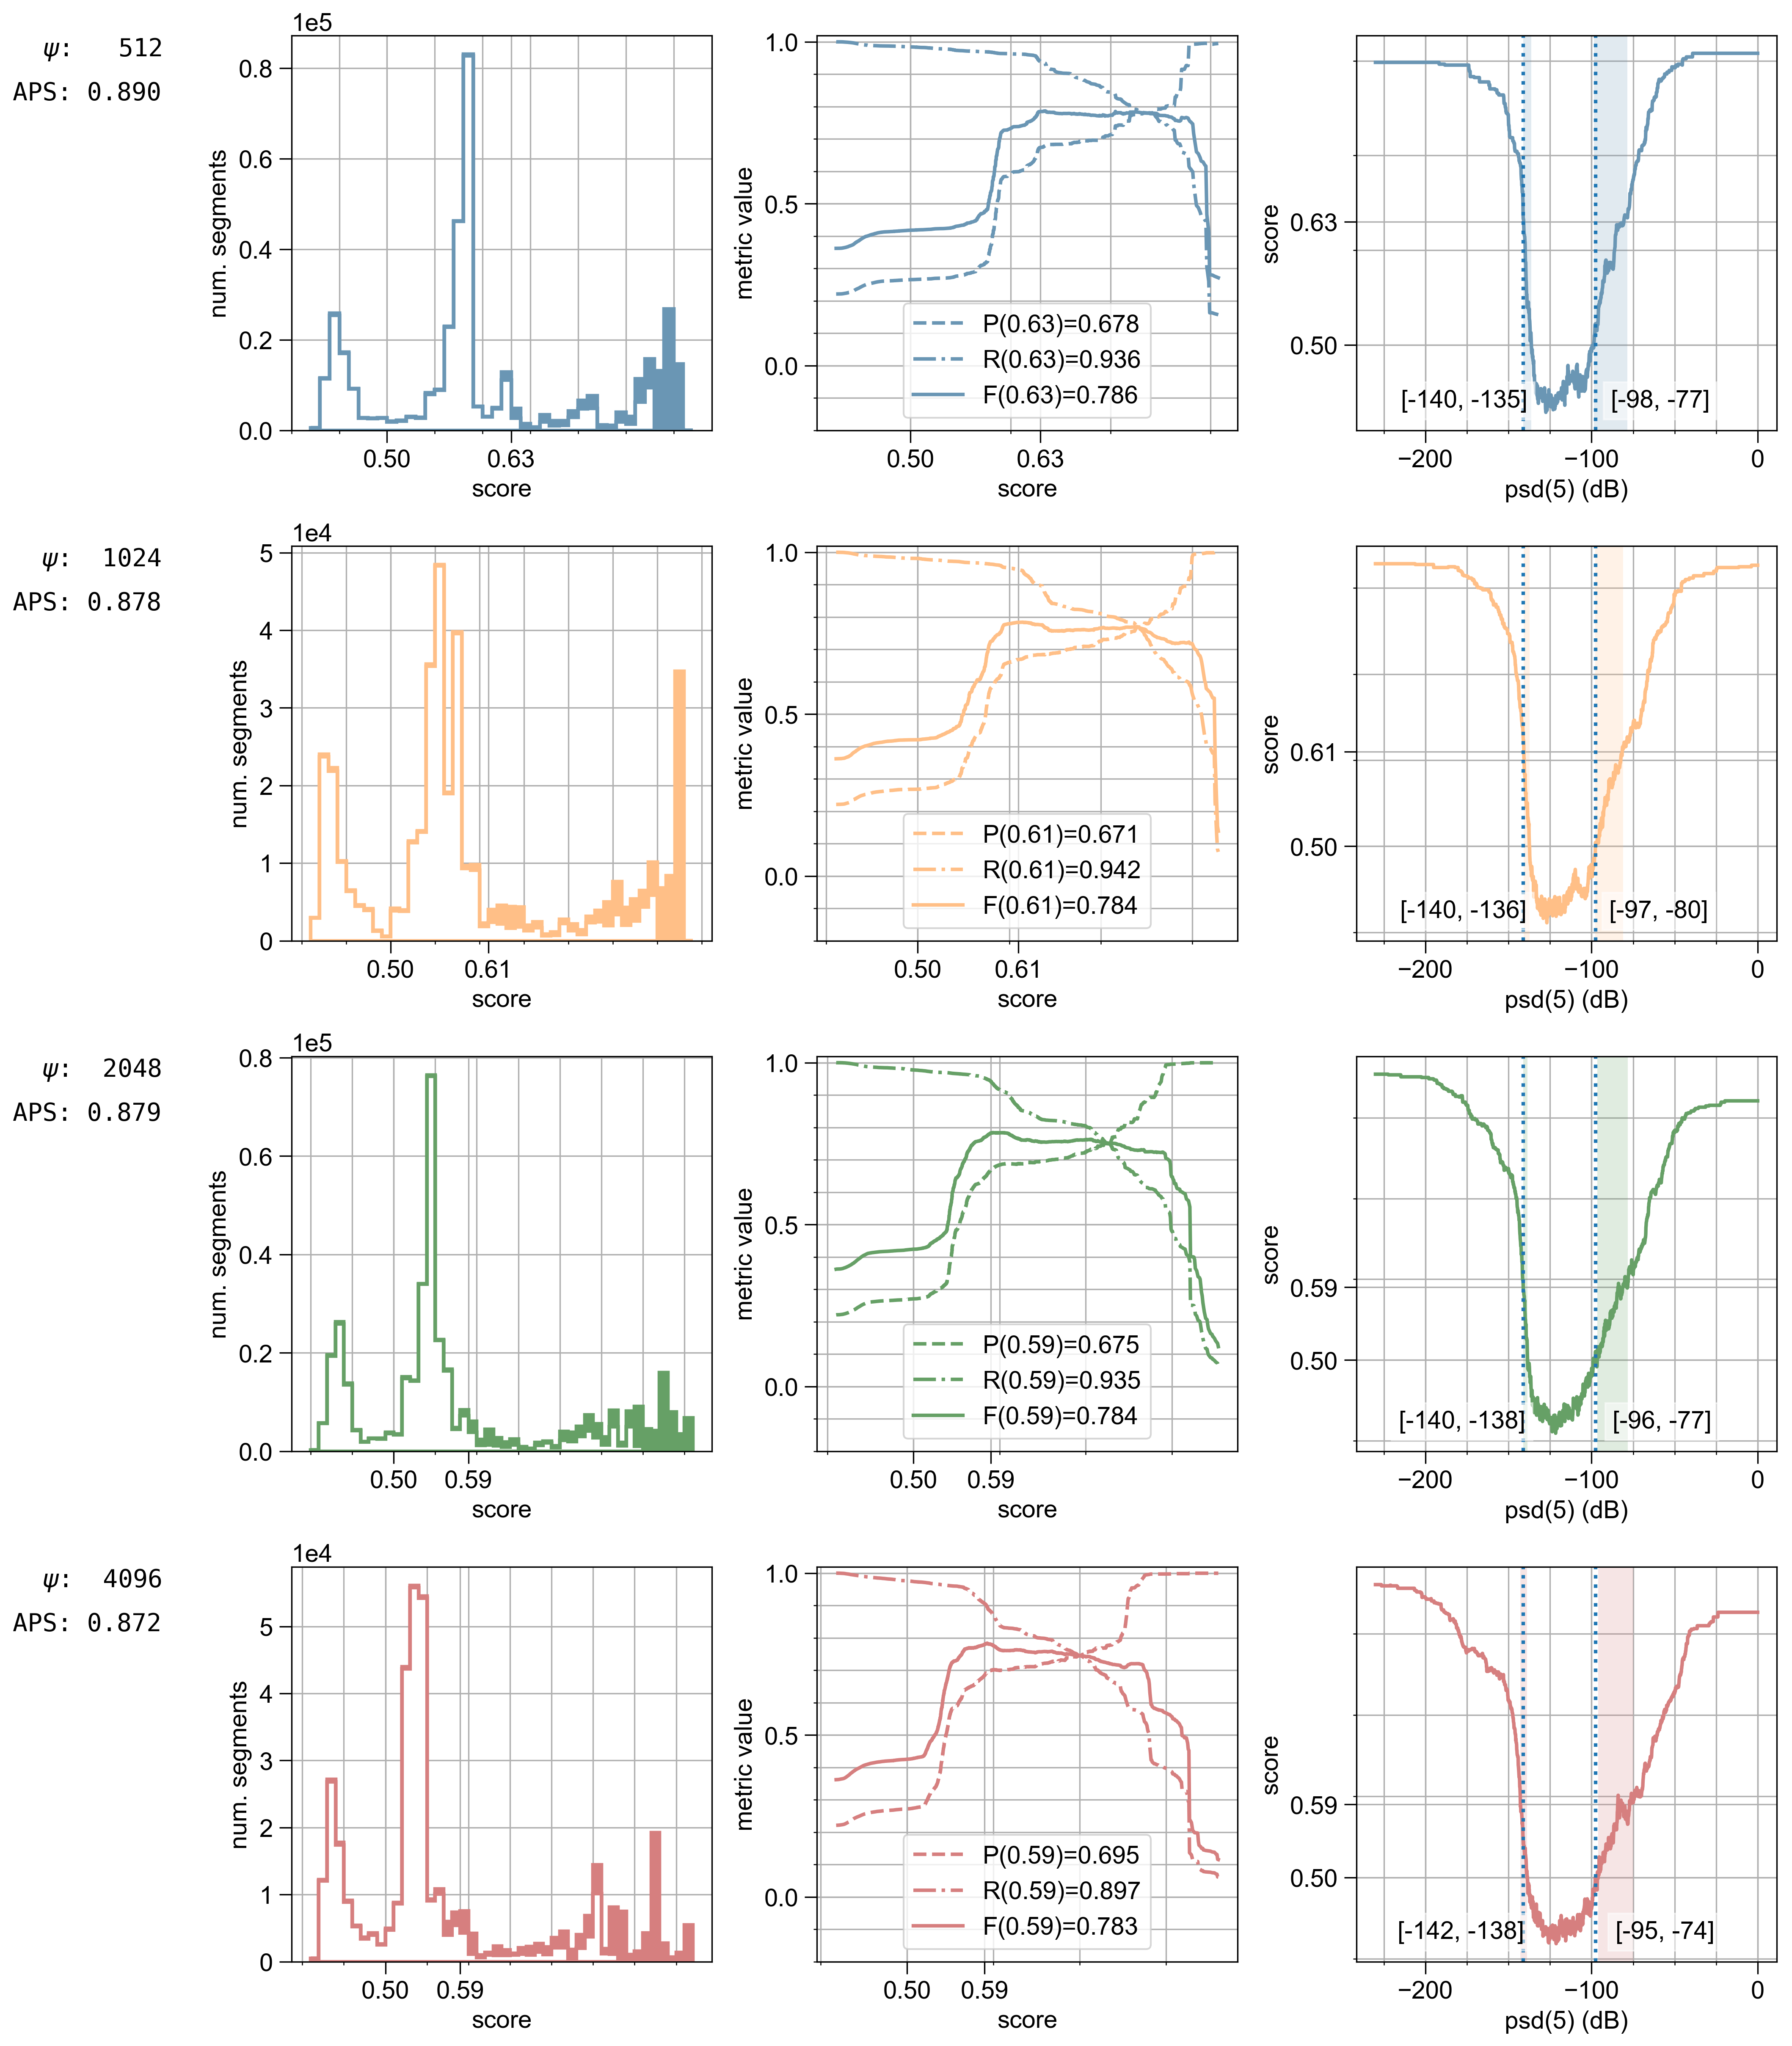

Plotting detailed model predictions on uniform_test.hdf, feats=psd@5sec, all datsets, n_estimators=50

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


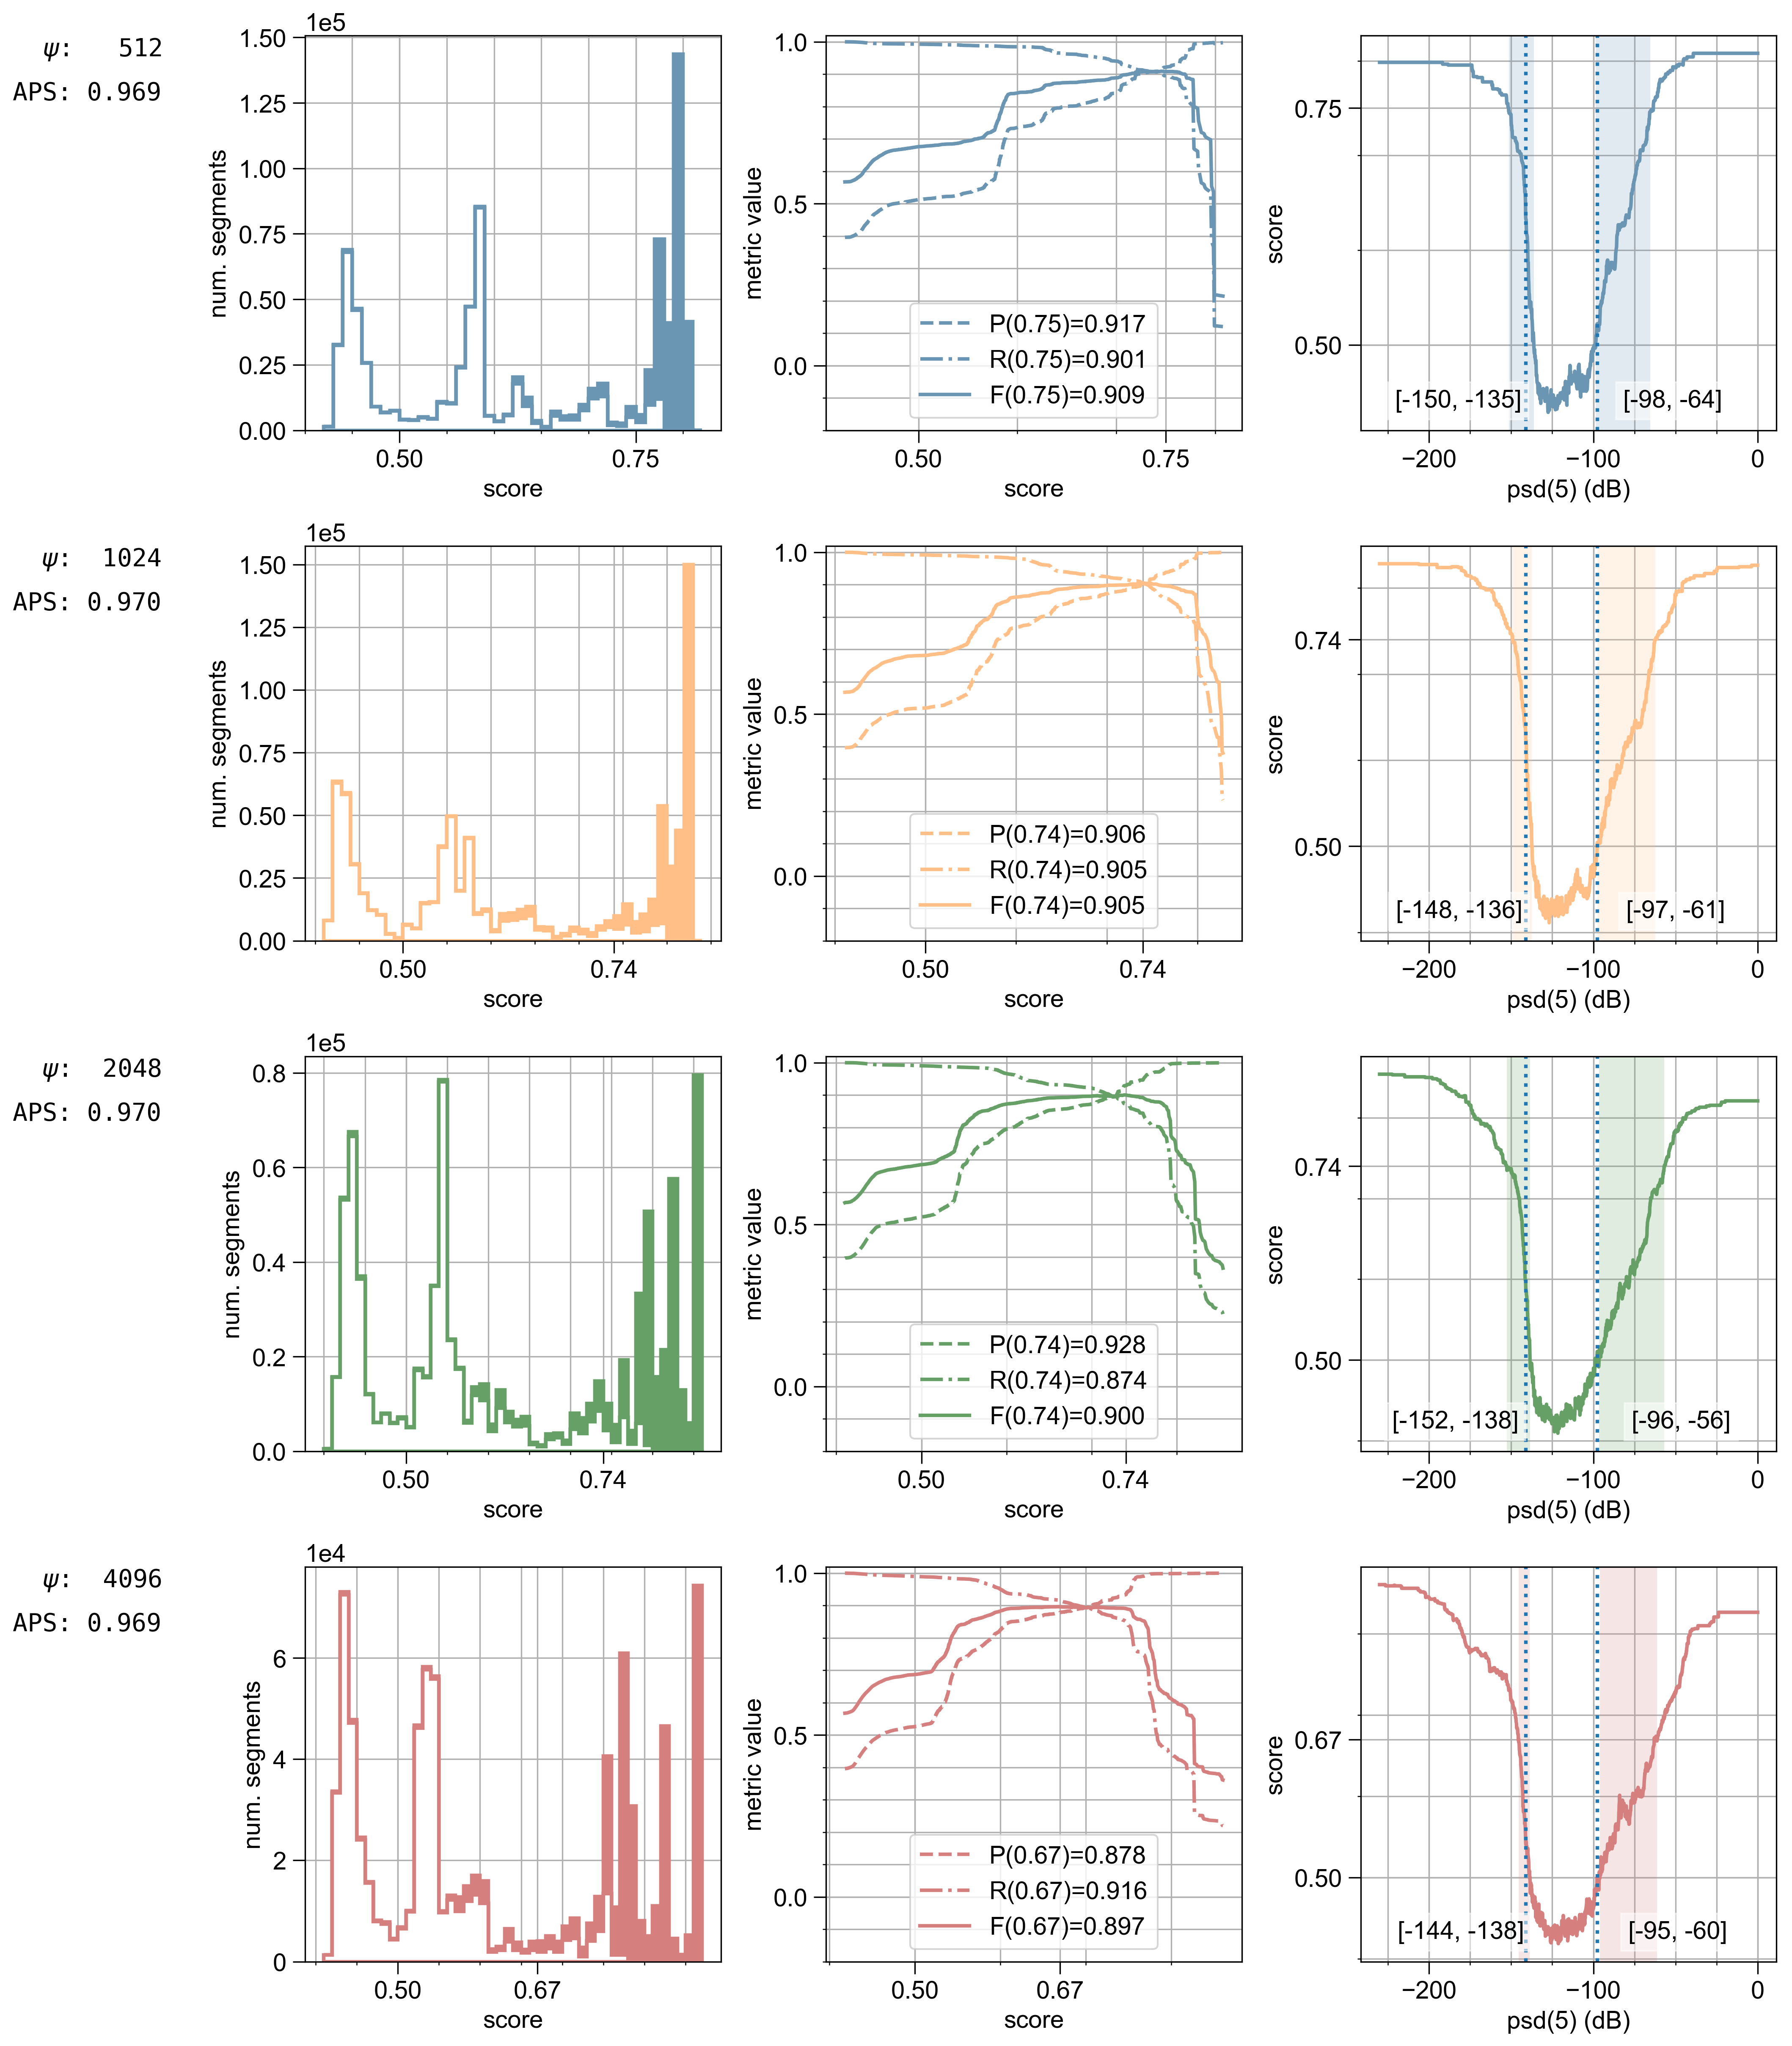

In [72]:
feats = 'psd@5sec'
nest = 50
did = 1

plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14
for nest in [nest]:  # [50, 100, 200]:
    print()
    printhtml(f'<h3>Plotting detailed model predictions on {setname}, feats={feats}, datset_id={did}, n_estimators=%d</h3>' % nest)
    pred_dfs = get_pred_dfs(_eval_df2[(_eval_df2.feats == feats) &
                                      (_eval_df2.n_estimators == nest)], columns=['predicted_anomaly_score',
                                                                              'window_type',
                                                                              'outlier',
                                                                              'dataset_id'])
    for _ in list(pred_dfs):
        pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==did)]  # & ((pred_dfs[_].window_type))]
    fig = plot_prediction_per_maxsamples(pred_dfs)
    savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
    plt.show()

    
# normal plots:    

for nest in [nest]:  # [50, 100, 200]:
    print()
    printhtml(f'<h3>Plotting detailed model predictions on {setname}, feats={feats}, all datsets, n_estimators=%d</h3>' % nest)
    pred_dfs = get_pred_dfs(_eval_df2[(_eval_df2.feats == feats) &
                                      (_eval_df2.n_estimators == nest)], columns=['predicted_anomaly_score',
                                                                              'window_type',
                                                                              'outlier',
                                                                              'dataset_id'])
#     for _ in list(pred_dfs):
#         pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==did)]  # & ((pred_dfs[_].window_type))]
    fig = plot_prediction_per_maxsamples(pred_dfs)
    savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
    plt.show()

plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15


In [54]:
printhtml('<h3>Ranking models (median across same random_state)</h3>')
APS = 'average_precision_score'
setnames = [TESTSETNAME_U, TESTSETNAME_U_1]
eval_df_median = []
for setname in setnames:
    eval_df2 = []
    for _, _df in eval_df[#(eval_df.feats == 'psd@5sec') &
                          (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
            groupby(['n_estimators', 'max_samples', 'feats']):
        _df = _df[_df[APS] == _df[APS].median()]
        assert len(_df) == 1
        eval_df2.append(_df)
        # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
    eval_df2 = pd.concat(eval_df2, axis=0, sort=False)
    printhtml(f'<h3>{APS} of {setname}</h3>')
    display(eval_df2[eval_df2.relative_filepath.str.endswith(os.sep + setname)].
            sort_values([APS], ascending=False)[EVALDF_DISPLAYCOLUMNS].head(25))

Ranking models (median across same random_state)

average_precision_score of uniform_test.hdf

clf                       feats  n_estimators  max_samples  \
1592  IsolationForest                    psd@5sec           100         1024   
1604  IsolationForest                    psd@5sec           100          512   
1599  IsolationForest                    psd@5sec            50         2048   
1596  IsolationForest                    psd@5sec           100         2048   
1595  IsolationForest                    psd@5sec            50         1024   
1602  IsolationForest                    psd@5sec           100         4096   
1606  IsolationForest                    psd@5sec            50          512   
1601  IsolationForest                    psd@5sec            50         4096   
1100  IsolationForest           psd@2sec,psd@5sec           100         4096   
1099  IsolationForest           psd@2sec,psd@5sec           100         2048   
1101  IsolationForest           psd@2sec,psd@5sec            50         4096   
1098  IsolationForest           psd@2sec,psd@5sec            50         2048   
1576  IsolationForest           psd@2sec,psd@5sec           100         1024   
1549  IsolationForest           psd@1sec,psd@5sec           100         2048   
1579  IsolationForest           psd@2sec,psd@5sec            50         1024   
1552  IsolationForest           psd@1sec,psd@5sec           100         4096   
1551  IsolationForest           psd@1sec,psd@5sec            50         2048   
1544  IsolationForest           psd@1sec,psd@5sec           100         1024   
1553  IsolationForest           psd@1sec,psd@5sec            50         4096   
1534  IsolationForest  psd@1sec,psd@2sec,psd@5sec            50         2048   
1590  IsolationForest           psd@2sec,psd@5sec            50          512   
1531  IsolationForest  psd@1sec,psd@2sec,psd@5sec            50         1024   
1081  IsolationForest           psd@1sec,psd@5sec            50         1024   
1536  IsolationForest  psd@1sec,psd@2sec,psd@5sec           100         4096   
1533  IsolationForest  psd@1sec,psd@2sec,psd@5sec           100         2048   

      random_state  average_precision_score  best_th_pr_curve  roc_auc_score  \
1592            11                 0.970564          0.739007       0.975348   
1604            11                 0.970490          0.743559       0.975866   
1599            11                 0.970213          0.737760       0.975100   
1596            11                 0.970131          0.723908       0.974888   
1595            25                 0.969853          0.739561       0.975201   
1602            25                 0.969622          0.680671       0.974166   
1606            11                 0.968845          0.745870       0.975527   
1601            11                 0.968842          0.668166       0.973910   
1100            42                 0.968784          0.648874       0.974015   
1099            42                 0.968290          0.650495       0.973734   
1101            42                 0.968233          0.649151       0.974114   
1098            42                 0.966971          0.664488       0.972821   
1576            11                 0.966856          0.675782       0.973292   
1549            25                 0.966650          0.656387       0.972446   
1579            25                 0.966441          0.668714       0.972620   
1552            11                 0.966222          0.647494       0.971932   
1551            25                 0.965309          0.649657       0.971270   
1544            11                 0.965096          0.673890       0.971940   
1553            11                 0.965071          0.659666       0.970099   
1534            11                 0.964736          0.637596       0.970350   
1590            25                 0.964619          0.677328       0.972053   
1531            25                 0.964542          0.642004       0.971158   
1081            42                 0.964340          0.668793       0.971049   
1536            1

average_precision_score of uniform_test_dataset1.hdf

clf                                  feats  n_estimators  \
2254  IsolationForest             psd@1sec,psd@2sec,psd@5sec            50   
2324  IsolationForest                      psd@2sec,psd@5sec           100   
2250  IsolationForest             psd@1sec,psd@2sec,psd@5sec           100   
2325  IsolationForest                      psd@2sec,psd@5sec            50   
2278  IsolationForest                      psd@1sec,psd@5sec            50   
2234  IsolationForest             psd@1sec,psd@2sec,psd@5sec           100   
2236  IsolationForest             psd@1sec,psd@2sec,psd@5sec            50   
2274  IsolationForest                      psd@1sec,psd@5sec           100   
1965  IsolationForest           psd@0.2sec,psd@2sec,psd@5sec            50   
1964  IsolationForest           psd@0.2sec,psd@2sec,psd@5sec           100   
2238  IsolationForest             psd@1sec,psd@2sec,psd@5sec           100   
2157  IsolationForest           psd@0.5sec,psd@2sec,psd@5sec            50   
1948  IsolationForest           psd@0.2sec,psd@2sec,psd@5sec            50   
2140  IsolationForest           psd@0.5sec,psd@2sec,psd@5sec            50   
1877  IsolationForest  psd@0.2sec,psd@1sec,psd@2sec,psd@5sec            50   
1946  IsolationForest           psd@0.2sec,psd@2sec,psd@5sec           100   
2306  IsolationForest                      psd@2sec,psd@5sec           100   
2243  IsolationForest             psd@1sec,psd@2sec,psd@5sec            50   
2067  IsolationForest  psd@0.5sec,psd@1sec,psd@2sec,psd@5sec            50   
2138  IsolationForest           psd@0.5sec,psd@2sec,psd@5sec           100   
2259  IsolationForest                      psd@1sec,psd@5sec            50   
1894  IsolationForest  psd@0.2sec,psd@1sec,psd@2sec,psd@5sec            50   
2073  IsolationForest  psd@0.5sec,psd@1sec,psd@2sec,psd@5sec            50   
2154  IsolationForest           psd@0.5sec,psd@2sec,psd@5sec           100   
2085  IsolationForest  psd@0.5sec,psd@1sec,psd@2sec,psd@5sec            50   

      max_samples  random_state  average_precision_score  best_th_pr_curve  \
2254          512            25                 0.911009          0.636657   
2324          512            42                 0.910691          0.653640   
2250          512            11                 0.909861          0.624740   
2325          512            11                 0.908866          0.637330   
2278          512            25                 0.906412          0.656075   
2234         1024            42                 0.905836          0.618406   
2236         1024            25                 0.905677          0.642004   
2274          512            11                 0.905438          0.651087   
1965          512            11                 0.903267          0.618241   
1964          512            42                 0.902658          0.634957   
2238         2048            11                 0.901841          0.634034   
2157          512            11                 0.901527          0.621692   
1948         1024            25                 0.900456          0.624687   
2140         1024            25                 0.900154          0.634891   
1877         1024            42                 0.899582          0.605298   
1946         1024            42                 0.899058          0.634119   
2306         1024            42                 0.899045          0.661798   
2243         2048            42                 0.899006          0.617135   
2067         1024            11                 0.898540          0.598469   
2138         1024            42                 0.898502          0.625630   
2259         1024            11                 0.898483          0.661982   
1894          512            25                 0.897790          0.596267   
2073         2048            11                 0.897580          0.554015   
2154          512            11                 0.897372          0.633076   
2085          512            11        

In [58]:
printhtml(f'Combining median on all {setname}')
eval_df2 = []

APSCOLS = ['aps_hmean', 'aps_total', 'aps_dataset1']

display_columns = EVALDF_DISPLAYCOLUMNS[:EVALDF_DISPLAYCOLUMNS.index(APS)] + APSCOLS + \
    EVALDF_DISPLAYCOLUMNS[EVALDF_DISPLAYCOLUMNS.index(APS)+1:]

for _, _df in eval_df[(eval_df.relative_filepath.str.endswith(os.sep + setnames[0])) | 
                      (eval_df.relative_filepath.str.endswith(os.sep + setnames[1]))].\
        groupby(['n_estimators', 'max_samples', 'feats', 'random_state']):
    assert len(_df) == 2
    _1 = _df.loc[_df.relative_filepath.str.endswith(TESTSETNAME_U_1), APS].iloc[0]
    _2 = _df.loc[~_df.relative_filepath.str.endswith(TESTSETNAME_U_1), APS].iloc[0]
    hmean = 2 * _1 * _2 / (_1 + _2)
    _df = _df[:1].copy()
    _df.loc[:, APSCOLS[0]] = hmean
    _df.loc[:, APSCOLS[1]] = _2
    _df.loc[:, APSCOLS[2]] = _1
    eval_df2.append(_df)
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

_eval_df2 = []
for _, _df in eval_df2.\
        groupby(['n_estimators', 'max_samples', 'feats']):
    assert len(_df) == 3
    _ = _df.sort_values([APS])[1:2]
    _eval_df2.append(_)

_eval_df2 = pd.concat(_eval_df2, axis=0, sort=False)
printhtml(f'<h3>Avergage precision score of {setnames} (hearmonic mean)</h3>')
display(_eval_df2.sort_values([APSCOLS[0]], ascending=False)[display_columns].head(25))

del eval_df2
# del _eval_df2

Combining median on all uniform_test_dataset1.hdf

Avergage precision score of ['uniform_test.hdf', 'uniform_test_dataset1.hdf'] (hearmonic mean)

clf                         feats  n_estimators  \
1589  IsolationForest             psd@2sec,psd@5sec           100   
1590  IsolationForest             psd@2sec,psd@5sec            50   
1531  IsolationForest    psd@1sec,psd@2sec,psd@5sec            50   
1529  IsolationForest    psd@1sec,psd@2sec,psd@5sec           100   
1557  IsolationForest             psd@1sec,psd@5sec           100   
1541  IsolationForest    psd@1sec,psd@2sec,psd@5sec            50   
1542  IsolationForest    psd@1sec,psd@2sec,psd@5sec           100   
1559  IsolationForest             psd@1sec,psd@5sec            50   
1533  IsolationForest    psd@1sec,psd@2sec,psd@5sec           100   
1604  IsolationForest                      psd@5sec           100   
1081  IsolationForest             psd@1sec,psd@5sec            50   
1576  IsolationForest             psd@2sec,psd@5sec           100   
1534  IsolationForest    psd@1sec,psd@2sec,psd@5sec            50   
1467  IsolationForest  psd@0.5sec,psd@2sec,psd@5sec            50   
1339  IsolationForest  psd@0.2sec,psd@2sec,psd@5sec            50   
1544  IsolationForest             psd@1sec,psd@5sec           100   
1100  IsolationForest             psd@2sec,psd@5sec           100   
976   IsolationForest  psd@0.2sec,psd@2sec,psd@5sec           100   
1477  IsolationForest  psd@0.5sec,psd@2sec,psd@5sec           100   
1579  IsolationForest             psd@2sec,psd@5sec            50   
1101  IsolationForest             psd@2sec,psd@5sec            50   
1099  IsolationForest             psd@2sec,psd@5sec           100   
1536  IsolationForest    psd@1sec,psd@2sec,psd@5sec           100   
1606  IsolationForest                      psd@5sec            50   
1040  IsolationForest  psd@0.5sec,psd@2sec,psd@5sec           100   

      max_samples  random_state  aps_hmean  aps_total  aps_dataset1  \
1589          512            25   0.936848   0.962738      0.912315   
1590          512            25   0.936104   0.964619      0.909226   
1531         1024            25   0.934183   0.964542      0.905677   
1529         1024            25   0.934169   0.962679      0.907300   
1557          512            25   0.934090   0.960488      0.909105   
1541          512            11   0.933705   0.955419      0.912956   
1542          512            25   0.933002   0.955489      0.911549   
1559          512            25   0.932706   0.960572      0.906412   
1533         2048            25   0.932593   0.963917      0.903240   
1604          512            11   0.932356   0.970490      0.897105   
1081         1024            42   0.931666   0.964340      0.901133   
1576         1024            11   0.931192   0.966856      0.898065   
1534         2048            11   0.930418   0.964736      0.898458   
1467         1024            25   0.930415   0.962780      0.900154   
1339         1024            25   0.929645   0.960790      0.900456   
1544         1024            11   0.929440   0.965096      0.896325   
1100         4096            42   0.929419   0.968784      0.893129   
976          1024            42   0.929402   0.961864      0.899058   
1477          512            25   0.929401   0.953286      0.906684   
1579         1024            25   0.929401   0.966441      0.895095   
1101         4096            42   0.928705   0.968233      0.892279   
1099         2048            42   0.928268   0.968290      0.891422   
1536         4096            11   0.928013   0.964123      0.894510   
1606          512            11   0.927998   0.968845      0.890457   
1040         1024            42   0.927739   0.958943      0.898502   

      best_th_pr_curve  roc_auc_score  log_loss  \
1589          0.659450       0.970948  0.581877   
1590          0.677328       0.972053  0.578153   
1531          0.642004       0.971158  0.550473   
1529          0.631918       0.969806  0.558078   
1557          0.661171       0.969250  0.592749   
1541          0.633497       0.966052  0.582988   
1542          0.624

Plotting detailed model predictions with n_estimators=100

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


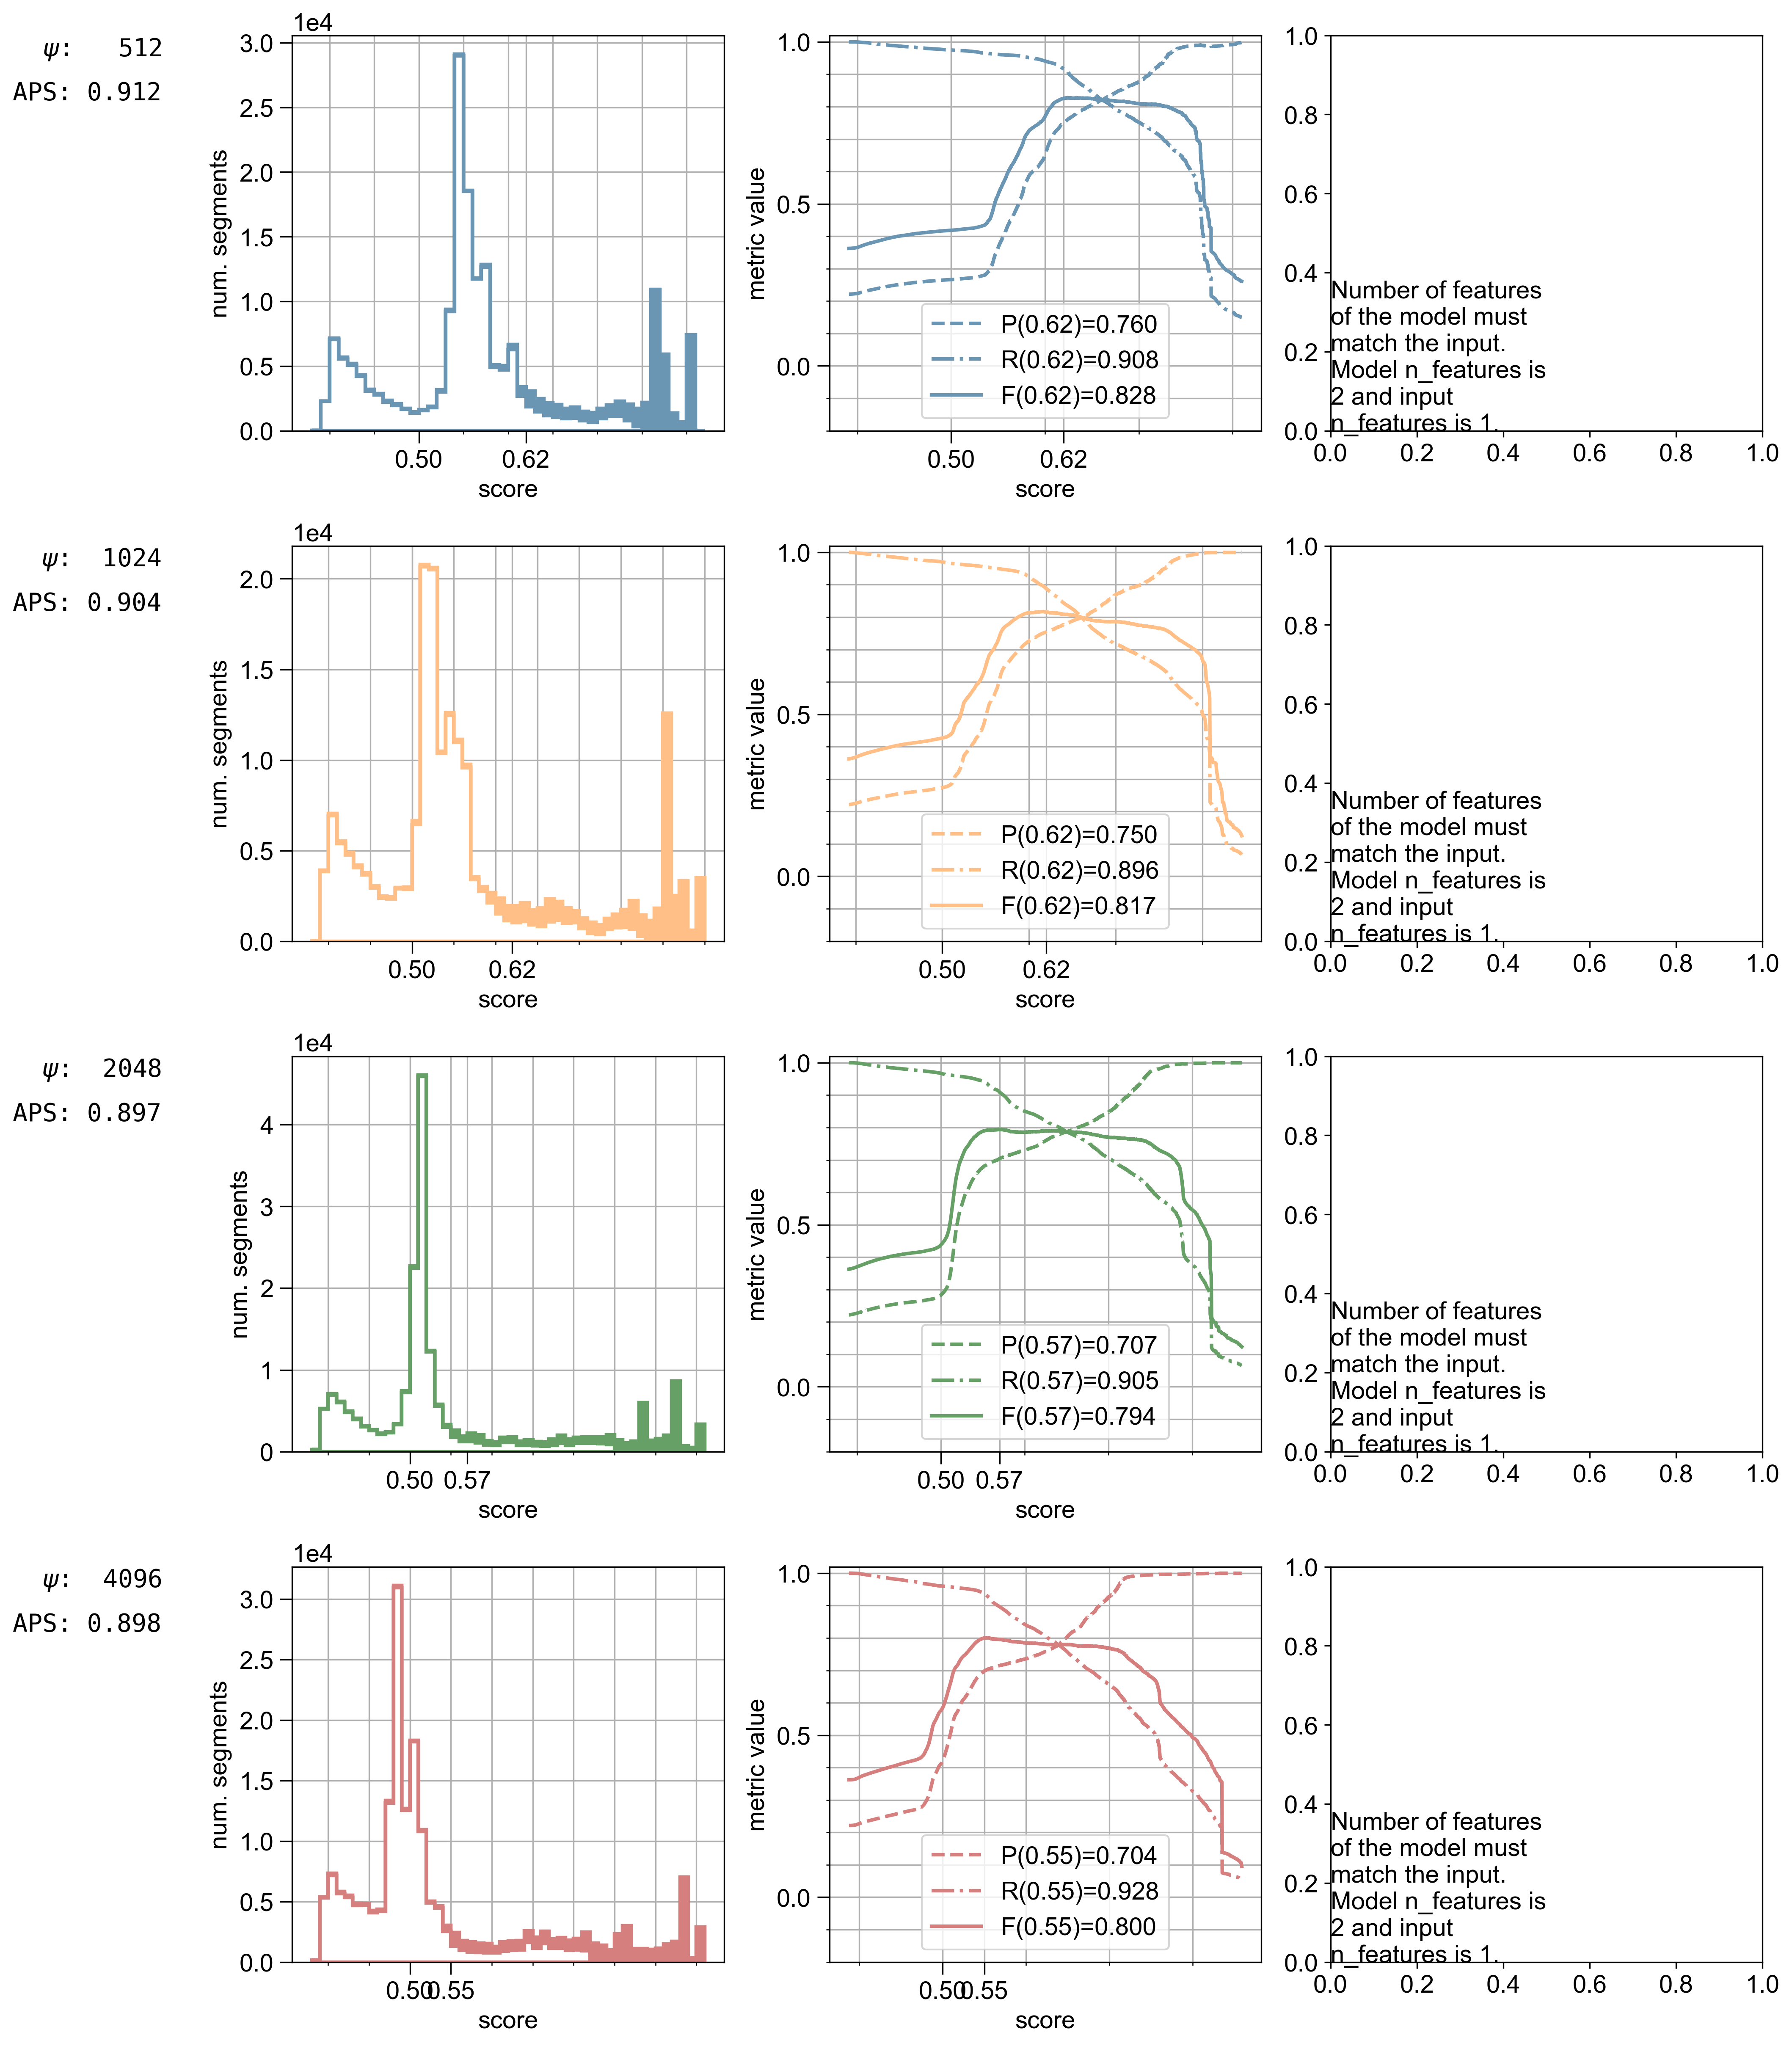

In [51]:
# printhtml(f'<h3>Loading {TESTSETNAME_U}</h3>')
# rootpath = os.path.join(os.path.dirname(os.getcwd()), 'datasets')
# testdf = pd.read_hdf(os.path.join(rootpath, TESTSETNAME_U),
#                     columns=['Segment.db.id', 'dataset_id', 'window_type', 'psd@5sec'])

# setname = TESTSETNAME_U

# printhtml('<h3>Plotting best models in details. All metrics computed on test set "%s"</h3>' % setname)


# printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
#           'average precision score</h3>')

# eval_df2 = []
# for _, _df in eval_df[(eval_df.feats == 'psd@5sec') &
#                       (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
#         groupby(['n_estimators', 'max_samples']):
#     _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
#     # _df = _df[_df.random_state == 11]
#     assert len(_df) == 1
#     eval_df2.append(_df)
#     # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
# eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

# pd.set_option('display.max_rows', 500)
# # display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))
# display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])



# printhtml('<h4>Defining plot function and plotting</h4>')




feats = 'psd@2sec,psd@5sec'
nest = 50

plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14
for nest in [100]:  # [50, 100, 200]:
    print()
    printhtml('<h4>Plotting detailed model predictions with n_estimators={nest</h4>' % nest)
    pred_dfs = get_pred_dfs(_eval_df2[(_eval_df2.feats == feats) &
                                      (_eval_df2.n_estimators == nest)], columns=['predicted_anomaly_score',
                                                                              'window_type',
                                                                              'outlier',
                                                                              'dataset_id'])
    for _ in list(pred_dfs):
        pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==1) & ((pred_dfs[_].window_type))]
    fig = plot_prediction_per_maxsamples(pred_dfs)
    savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
    plt.show()
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15


Plotting best models in details. All metrics computed on test set "uniform_test.hdf"

Grouping models by (n_estimators, max_samples) and keeping those with median average precision score

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   
1604  IsolationForest  psd@5sec           100          512            11   
1599  IsolationForest  psd@5sec            50         2048            11   
1596  IsolationForest  psd@5sec           100         2048            11   
1595  IsolationForest  psd@5sec            50         1024            25   
1602  IsolationForest  psd@5sec           100         4096            25   
1606  IsolationForest  psd@5sec            50          512            11   
1601  IsolationForest  psd@5sec            50         4096            11   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   
1604                 0.970490          0.743559       0.975866  0.604658   
1599                 0.970213          0.737760       0.975100  0.559445   
1596                 0.970131          0.723908       0.974888  0.559709   
1595                 0.969853          0.739561       0.975201  0.574039   
1602                 0.969622          0.680671       0.974166  0.556366   
1606                 0.968845          0.745870       0.975527  0.605512   
1601                 0.968842          0.668166       0.973910  0.556683   

                                                                                                                                                    relative_filepath  
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
1604   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1599   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=50&random_state=11/uniform_test.hdf  
1596  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1595   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=50&random_state=25/uniform_test.hdf  
1602  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf  
1606    clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=50&random_state=11/uniform_test.hdf  
1601   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=50&random_state=11/uniform_test.hdf

Defining plot function and plotting

Plotting detailed model predictions with n_estimators=100

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

(SAVE_FIGURES=False)


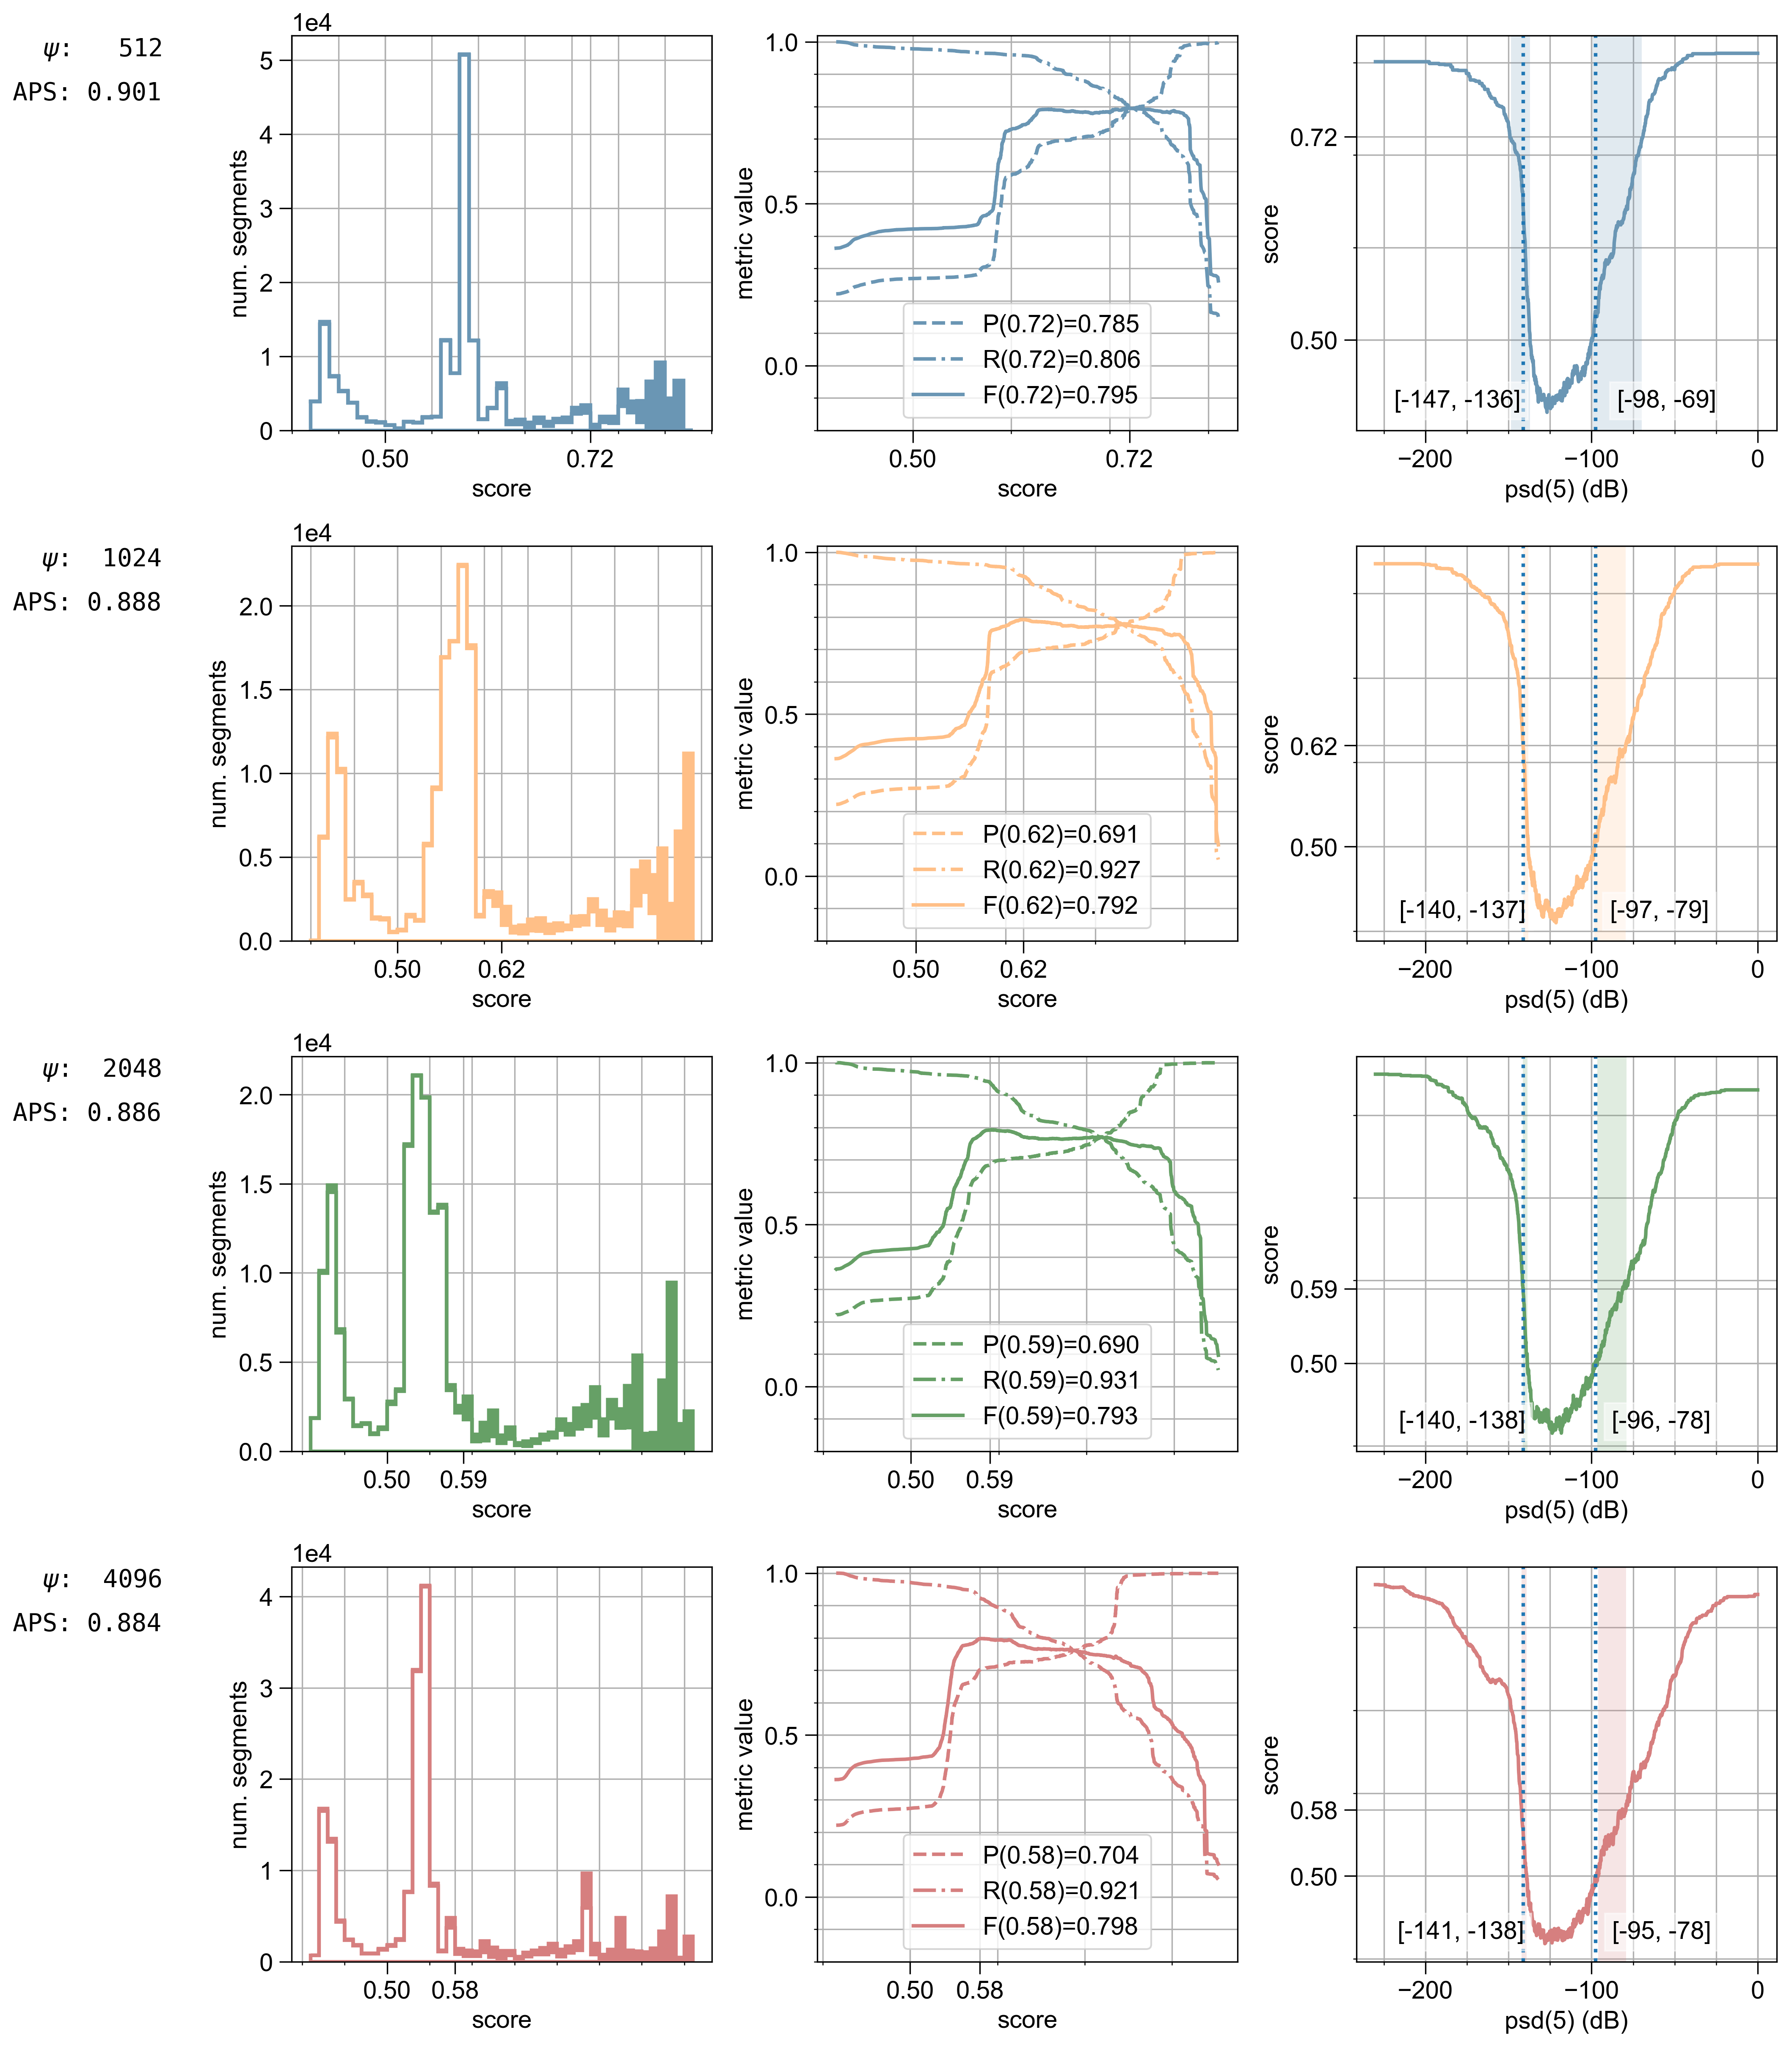

In [9]:
setname = TESTSETNAME_U

printhtml('<h3>Plotting best models in details. All metrics computed on test set "%s"</h3>' % setname)


printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
          'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])



printhtml('<h4>Defining plot function and plotting</h4>')





plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14
for nest in [100]:  # [50, 100, 200]:
    print()
    printhtml('<h4>Plotting detailed model predictions with n_estimators=%d</h4>' % nest)
    pred_dfs = get_pred_dfs(eval_df2[eval_df2.n_estimators == nest], columns=['predicted_anomaly_score',
                                                                              'window_type',
                                                                              'outlier',
                                                                              'dataset_id'])
    for _ in list(pred_dfs):
        pred_dfs[_] = pred_dfs[_][(pred_dfs[_].dataset_id==1) & ((pred_dfs[_].window_type))]
    fig = plot_prediction_per_maxsamples(pred_dfs)
    savefig(fig, 'feat5sec_allperfs_nest=%d' % nest)
    plt.show()
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15


In [ ]:
raise




















In [59]:
setname = TESTSETNAME_U
n_est = 100

# printhtml('<h3>Performances per dataset. All metrics computed on test set "%s"</h3>' % setname)


# printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
#           'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))

printhtml(f'Performances on "{setname}" (same as previous Notebook cell but restricted to n_estimators={n_est})"')
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score',
                                           'channel_code',
                                           'station_id', 'Segment.db.id', 'outlier', 'window_type', 'dataset_id', 'magnitude'])

from collections import defaultdict
metricname = 'average_precision_score'

# printhtml(f'Performances on "{setname}" (SIGNAL WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

# printhtml(f'Performances on "{setname}" (NOISE WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[~p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

hls = read_handlabelled_segments()

for did in [1, 2, 4]:
    for wtype in (True, False):
        wtype_str = 'SIGNAL' if wtype else 'NOISE'
        print()
        print()
        printhtml(f'Performances on "{setname}" ({wtype_str} WINDOWS ONLY, DATASET_ID={did})')
        dic = defaultdict(list)
        for tupl, p in pred_dfs.items():
            _p = p[(p.dataset_id == did) & (p.window_type == wtype)]
            lenp_ = len(_p)
            # oldlen = len(_p)
            # _p = _p[(~_p.dataset_id.isin(hls.dataset_id)) | (~_p['Segment.db.id'].isin(hls['Segment.db.id']))]
            # assert (len(_p)) < oldlen

            # print misclassified:
#             _p = _p[~_p.station_id.isin([5831, 5833, 10179, 10186, 890])]
#             miscl = [str(_) for _ in _p[(_p.outlier) & (_p.predicted_anomaly_score <0.7) ]['Segment.db.id']][:50]
#             print(f'Outliers missclassified ({len(miscl)})')
#             print(" ".join(miscl))
            
            _p = _p[~_p.station_id.isin([5831, 5833, 10179, 10186, 890])]
            _p = _p[(_p.outlier) & (_p.predicted_anomaly_score < 0.75)]
            _ = pd.unique(_p.channel_code)
            print(f'Segments missclassified: {len(_p)}/{lenp_} Channels missclassified ({len(_)})')
            print(_)
            
            aps = EVALMETRICS.APS.compute(_p)
            dic[metricname] += [aps]
            for fld in tupl._fields:
                if fld != metricname:
                    dic[fld] += [getattr(tupl, fld)]
        display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

                      
# for _ in eval_df.itertuples():
#     pred_df = get_pred_df
# display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on "uniform_test.hdf" (same as previous Notebook cell but restricted to n_estimators=100)"

clf     feats  n_estimators  max_samples  random_state  \
1592  IsolationForest  psd@5sec           100         1024            11   
1604  IsolationForest  psd@5sec           100          512            11   
1596  IsolationForest  psd@5sec           100         2048            11   
1602  IsolationForest  psd@5sec           100         4096            25   

      average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1592                 0.970564          0.739007       0.975348  0.577372   
1604                 0.970490          0.743559       0.975866  0.604658   
1596                 0.970131          0.723908       0.974888  0.559709   
1602                 0.969622          0.680671       0.974166  0.556366   

                                                                                                                                                    relative_filepath  
1592  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
1604   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1596  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
1602  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Loading 4 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=1)

Segments missclassified: 11042/201307 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'HNN' 'EHE' 'EHN' 'EHZ'
 'HH1' 'HH2' 'HH3']
Segments missclassified: 11372/201307 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'EHE' 'EHN'
 'HNN' 'EHZ' 'HH3']
Segments missclassified: 14280/201307 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'EHE' 'EHN'
 'HNN' 'EHZ' 'HH3']
Segments missclassified: 18578/201307 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'EHE' 'EHN'
 'HNN' 'EHZ' 'HH3']


clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=1)

Segments missclassified: 10619/201077 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'HNN' 'EHE'
 'EHN' 'EHZ' 'HH3']
Segments missclassified: 10995/201077 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'HNN' 'EHE'
 'EHN' 'EHZ' 'HH3']
Segments missclassified: 13986/201077 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'HNN' 'EHE'
 'EHN' 'EHZ' 'HH3']
Segments missclassified: 18411/201077 Channels missclassified (15)
['DHE' 'DHN' 'DHZ' 'HH1' 'HH2' 'HHZ' 'HHE' 'HHN' 'HNE' 'HNZ' 'HNN' 'EHE'
 'EHN' 'EHZ' 'HH3']


clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=2)

Segments missclassified: 9748/216909 Channels missclassified (1)
['BHZ']
Segments missclassified: 8649/216909 Channels missclassified (1)
['BHZ']
Segments missclassified: 13056/216909 Channels missclassified (1)
['BHZ']
Segments missclassified: 41630/216909 Channels missclassified (1)
['BHZ']


clf     feats  n_estimators  max_samples  random_state  \
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
0  IsolationForest  psd@5sec           100          512            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
0                      1.0          0.743559       0.975866  0.604658   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Performances on "uniform_test.hdf" (NOISE WINDOWS ONLY, DATASET_ID=2)

Segments missclassified: 4039/216900 Channels missclassified (1)
['BHZ']
Segments missclassified: 4417/216900 Channels missclassified (1)
['BHZ']
Segments missclassified: 6193/216900 Channels missclassified (1)
['BHZ']
Segments missclassified: 20511/216900 Channels missclassified (1)
['BHZ']


clf     feats  n_estimators  max_samples  random_state  \
0  IsolationForest  psd@5sec           100          512            11   
1  IsolationForest  psd@5sec           100         1024            11   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            25   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
0                      1.0          0.743559       0.975866  0.604658   
1                      1.0          0.739007       0.975348  0.577372   
2                      1.0          0.723908       0.974888  0.559709   
3                      1.0          0.680671       0.974166  0.556366   

                                                                                                                                                 relative_filepath  
0   clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/uniform_test.hdf  
1  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/uniform_test.hdf  
2  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/uniform_test.hdf  
3  clf=IsolationForest&tr_set=uniform_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=25/uniform_test.hdf

Performances on "uniform_test.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=4)

Segments missclassified: 0/885 Channels missclassified (0)
[]


IndexError: cannot do a non-empty take from an empty axes.

In [18]:
preddf = next(iter(pred_dfs.values()))
preddf = preddf[preddf.dataset_id==1]
ID = 21293504  # 24568450
  #14292427  # 30740284
display(preddf[preddf['Segment.db.id'] == ID])
display(testdf[testdf['Segment.db.id'] == ID])

predicted_anomaly_score  station_id  Segment.db.id  outlier  \
699759                 0.621048        4762       21293504     True   
699760                 0.678568        4762       21293504     True   

        window_type  dataset_id  magnitude  
699759        False           1        2.9  
699760         True           1        2.9

Segment.db.id  dataset_id  window_type   psd@5sec
699759       21293504           1        False -84.640236
699760       21293504           1         True -74.865521

In [20]:
setname = TESTSETNAME_12
n_est = 100

# printhtml('<h3>Performances per dataset. All metrics computed on test set "%s"</h3>' % setname)


# printhtml('<h4>Grouping models by (n_estimators, max_samples) and keeping those with median '
#           'average precision score</h3>')

eval_df2 = []
for _, _df in eval_df[(eval_df.feats == 'psd@5sec') & (eval_df.n_estimators == n_est) &
                      (eval_df.relative_filepath.str.endswith(os.sep + setname))].\
        groupby(['n_estimators', 'max_samples']):
    _df = _df[_df.average_precision_score == _df.average_precision_score.median()]
    # _df = _df[_df.random_state == 11]
    assert len(_df) == 1
    eval_df2.append(_df)
    # eval_df2.append(_df.sort_values('average_precision_score')[1:2])  # median
eval_df2 = pd.concat(eval_df2, axis=0, sort=False)

pd.set_option('display.max_rows', 500)
# display(eval_df.sort_values(['average_precision_score'], ascending=False).head(30))

printhtml(f'Performances on "{setname}" (same as previous Notebook cell but restricted to n_estimators={n_est})"')
display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

printhtml(f'Loading {len(eval_df2)} prediction dataframes to compute intra metrics')
pred_dfs = get_pred_dfs(eval_df2, columns=['predicted_anomaly_score','station_id', 'Segment.db.id', 'outlier', 'window_type', 'dataset_id', 'magnitude'])

from collections import defaultdict
metricname = 'average_precision_score'

# printhtml(f'Performances on "{setname}" (SIGNAL WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

# printhtml(f'Performances on "{setname}" (NOISE WINDOWS ONLY)')
# dic = defaultdict(list)
# for tupl, p in pred_dfs.items():
#     aps = EVALMETRICS.APS.compute(p[~p.window_type])
#     dic[metricname] += [aps]
#     for fld in tupl._fields:
#         if fld != metricname:
#             dic[fld] += [getattr(tupl, fld)]
# display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

hls = read_handlabelled_segments()

for did in [1, 2, 4]:
    for wtype in (True, False):
        wtype_str = 'SIGNAL' if wtype else 'NOISE'
        print()
        print()
        printhtml(f'Performances on "{setname}" ({wtype_str} WINDOWS ONLY, DATASET_ID={did})')
        dic = defaultdict(list)
        for tupl, p in pred_dfs.items():
            _p = p[(p.dataset_id == did) & (p.window_type == wtype)]
            
            # oldlen = len(_p)
            # _p = _p[(~_p.dataset_id.isin(hls.dataset_id)) | (~_p['Segment.db.id'].isin(hls['Segment.db.id']))]
            # assert (len(_p)) < oldlen

            # print misclassified:
            _p = _p[~_p.station_id.isin([5831, 5833, 10179, 10186, 890])]
            miscl = [str(_) for _ in _p[(_p.outlier) & (_p.predicted_anomaly_score <0.7) ]['Segment.db.id']][:50]
            print(f'Outliers missclassified ({len(miscl)})')
            print(" ".join(miscl))
            
            aps = EVALMETRICS.APS.compute(_p)
            dic[metricname] += [aps]
            for fld in tupl._fields:
                if fld != metricname:
                    dic[fld] += [getattr(tupl, fld)]
        display(pd.DataFrame(dic).sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

                      
# for _ in eval_df.itertuples():
#     pred_df = get_pred_df
# display(eval_df2.sort_values(['average_precision_score'], ascending=False)[EVALDF_DISPLAYCOLUMNS])

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (same as previous Notebook cell but restricted to n_estimators=100)"

clf     feats  n_estimators  max_samples  random_state  \
828  IsolationForest  psd@5sec           100         2048            11   
857  IsolationForest  psd@5sec           100         8192            42   
837  IsolationForest  psd@5sec           100         4096            11   
821  IsolationForest  psd@5sec           100        16384            42   
810  IsolationForest  psd@5sec           100         1024            11   
846  IsolationForest  psd@5sec           100          512            11   

     average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
828                 0.970464          0.756818       0.974035  0.610812   
857                 0.970154          0.679810       0.973168  0.582394   
837                 0.970058          0.726503       0.973940  0.588319   
821                 0.968372          0.662787       0.972020  0.578518   
810                 0.967977          0.769510       0.973106  0.631382   
846                 0.957958          0.772101       0.969529  0.671435   

                                                                                                                                                                                    relative_filepath  
828   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
857   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
837   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
821  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
810   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
846    clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf

Loading 6 prediction dataframes to compute intra metrics

[●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●] 100.0% 0:00:00

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=1)

Outliers missclassified (50)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 21965330 21965331 21965332 21969437 21969438 21970760 21970761 21971777 21971778 21972032 21972033 21972034 21972386 21972387 21972527 21972528 21972947 21972948 17094338 23546876 23547365 23547866 23548325 23548745 23549150 23549819 23550770 23551262 23552510 23552915 23553404 23553968 23554364 23554862
Outliers missclassified (50)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 21965330 21965331 21965332 21969437 21969438 21970760 21970761 21971777 21971778 21972032 21972033 21972034 21972386 21972387 21972527 21972528 21972947 21972948 17094338 23546876 23547365 23547866 23548325 23548745 23549150 23549819 23550770 23551262 23552021 23552510 23552915 23553404 23553968 23554364
Outliers missclassified (50)
11107330 1110

clf     feats  n_estimators  max_samples  random_state  \
1  IsolationForest  psd@5sec           100         1024            11   
0  IsolationForest  psd@5sec           100          512            11   
2  IsolationForest  psd@5sec           100         2048            11   
4  IsolationForest  psd@5sec           100         8192            42   
3  IsolationForest  psd@5sec           100         4096            11   
5  IsolationForest  psd@5sec           100        16384            42   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1                 0.908481          0.769510       0.973106  0.631382   
0                 0.903823          0.772101       0.969529  0.671435   
2                 0.902425          0.756818       0.974035  0.610812   
4                 0.901213          0.679810       0.973168  0.582394   
3                 0.900495          0.726503       0.973940  0.588319   
5                 0.899300          0.662787       0.972020  0.578518   

                                                                                                                                                                                  relative_filepath  
1   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
0    clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
2   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
4   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
3   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
5  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (NOISE WINDOWS ONLY, DATASET_ID=1)

Outliers missclassified (50)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 18491064 18491065 21807503 24136156 24136157 24136158 24801959 24801961 25048113 25096055 25096056 25109913 25126181 25142091 25166367 25177213 25216705 25238731 25276345 25283551 25288822 25296573 25302850 25308536 25310813 25312924 25315849 25338464 25341673 25344250 25350011
Outliers missclassified (50)
11107330 11107332 11108200 11108202 11108204 10368544 10368546 17082372 17082373 17082374 12700503 12700504 12700505 19701983 19701984 19701985 17361825 17361826 17361827 16642257 18491064 18491065 21807503 24136156 24136157 24136158 24801959 24801961 25037420 25048113 25096055 25096056 25109913 25126181 25142091 25166367 25177213 25216705 25238731 25276345 25283551 25288822 25296573 25302850 25308536 25310813 25312924 25315849 25338464 25341673
Outliers missclassified (50)
11107330 1110

clf     feats  n_estimators  max_samples  random_state  \
1  IsolationForest  psd@5sec           100         1024            11   
0  IsolationForest  psd@5sec           100          512            11   
2  IsolationForest  psd@5sec           100         2048            11   
4  IsolationForest  psd@5sec           100         8192            42   
3  IsolationForest  psd@5sec           100         4096            11   
5  IsolationForest  psd@5sec           100        16384            42   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
1                 0.906254          0.769510       0.973106  0.631382   
0                 0.904544          0.772101       0.969529  0.671435   
2                 0.898657          0.756818       0.974035  0.610812   
4                 0.898027          0.679810       0.973168  0.582394   
3                 0.897238          0.726503       0.973940  0.588319   
5                 0.896440          0.662787       0.972020  0.578518   

                                                                                                                                                                                  relative_filepath  
1   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
0    clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
2   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
4   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
3   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
5  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=2)

Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 1836968 1838644 1840219 1841464 1853930 19909 123976 265040 278168 292046 320947 367966 479126 1803480 1804668 1805243 1807107 1811522 1814880 1817060 1818202
Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 1836968 1838644 1839860 1840219 1841464 1842683 1853930 19909 38030 45491 123976 249635 258126 265040 278168 292046 320947 352411 367966 401537
Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 836794 838622 1836968 1838644 1839860 1840219 1841464 1842683 1853930 19909 38030 45491 123976 248845 2

clf     feats  n_estimators  max_samples  random_state  \
2  IsolationForest  psd@5sec           100         2048            11   
4  IsolationForest  psd@5sec           100         8192            42   
3  IsolationForest  psd@5sec           100         4096            11   
5  IsolationForest  psd@5sec           100        16384            42   
1  IsolationForest  psd@5sec           100         1024            11   
0  IsolationForest  psd@5sec           100          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
2                 0.981303          0.756818       0.974035  0.610812   
4                 0.981282          0.679810       0.973168  0.582394   
3                 0.981045          0.726503       0.973940  0.588319   
5                 0.979808          0.662787       0.972020  0.578518   
1                 0.973753          0.769510       0.973106  0.631382   
0                 0.957095          0.772101       0.969529  0.671435   

                                                                                                                                                                                  relative_filepath  
2   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
4   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
3   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
5  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
1   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
0    clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (NOISE WINDOWS ONLY, DATASET_ID=2)

Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 1836968 1838644 1839860 1840219 1841464 1842683 1853930 1962871 1055837 1550102 1666333 1685871 5551153 5570432 5587497 5588605 1055839 1550104 1666335 1685873
Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 1836968 1838644 1839860 1840219 1841464 1842683 1853930 249635 250484 258126 1864076 1962871 1055837 1072663 1099690 1430003 1430415 1550102 1666333 1685871
Outliers missclassified (50)
16 1106 3134 5168 7023 8472 9781 10954 13067 15084 16247 17476 19254 20935 21831 23246 24711 25979 27192 28440 31926 33610 87697 89054 90157 91025 92182 93921 94637 95516 808371 838622 1836968 1838644 1839860 1840219 1841464 1842683 1853930 248845 249635

clf     feats  n_estimators  max_samples  random_state  \
4  IsolationForest  psd@5sec           100         8192            42   
2  IsolationForest  psd@5sec           100         2048            11   
3  IsolationForest  psd@5sec           100         4096            11   
5  IsolationForest  psd@5sec           100        16384            42   
1  IsolationForest  psd@5sec           100         1024            11   
0  IsolationForest  psd@5sec           100          512            11   

   average_precision_score  best_th_pr_curve  roc_auc_score  log_loss  \
4                 0.995014          0.679810       0.973168  0.582394   
2                 0.995014          0.756818       0.974035  0.610812   
3                 0.994782          0.726503       0.973940  0.588319   
5                 0.994367          0.662787       0.972020  0.578518   
1                 0.993646          0.769510       0.973106  0.631382   
0                 0.987889          0.772101       0.969529  0.671435   

                                                                                                                                                                                  relative_filepath  
4   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=8192&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
2   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
3   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=4096&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
5  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=16384&n_estimators=100&random_state=42/allset_test_AND_allset_unlabelled_annotation2.hdf  
1   clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=1024&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf  
0    clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=512&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf

Performances on "allset_test_AND_allset_unlabelled_annotation2.hdf" (SIGNAL WINDOWS ONLY, DATASET_ID=4)

Outliers missclassified (0)



IndexError: cannot do a non-empty take from an empty axes.

['HHN', 'HNN', 'HNE', 'HNZ', 'BHN', 'HGN', 'HHE', 'HHZ', 'HLN', 'BHE', 'BHZ']


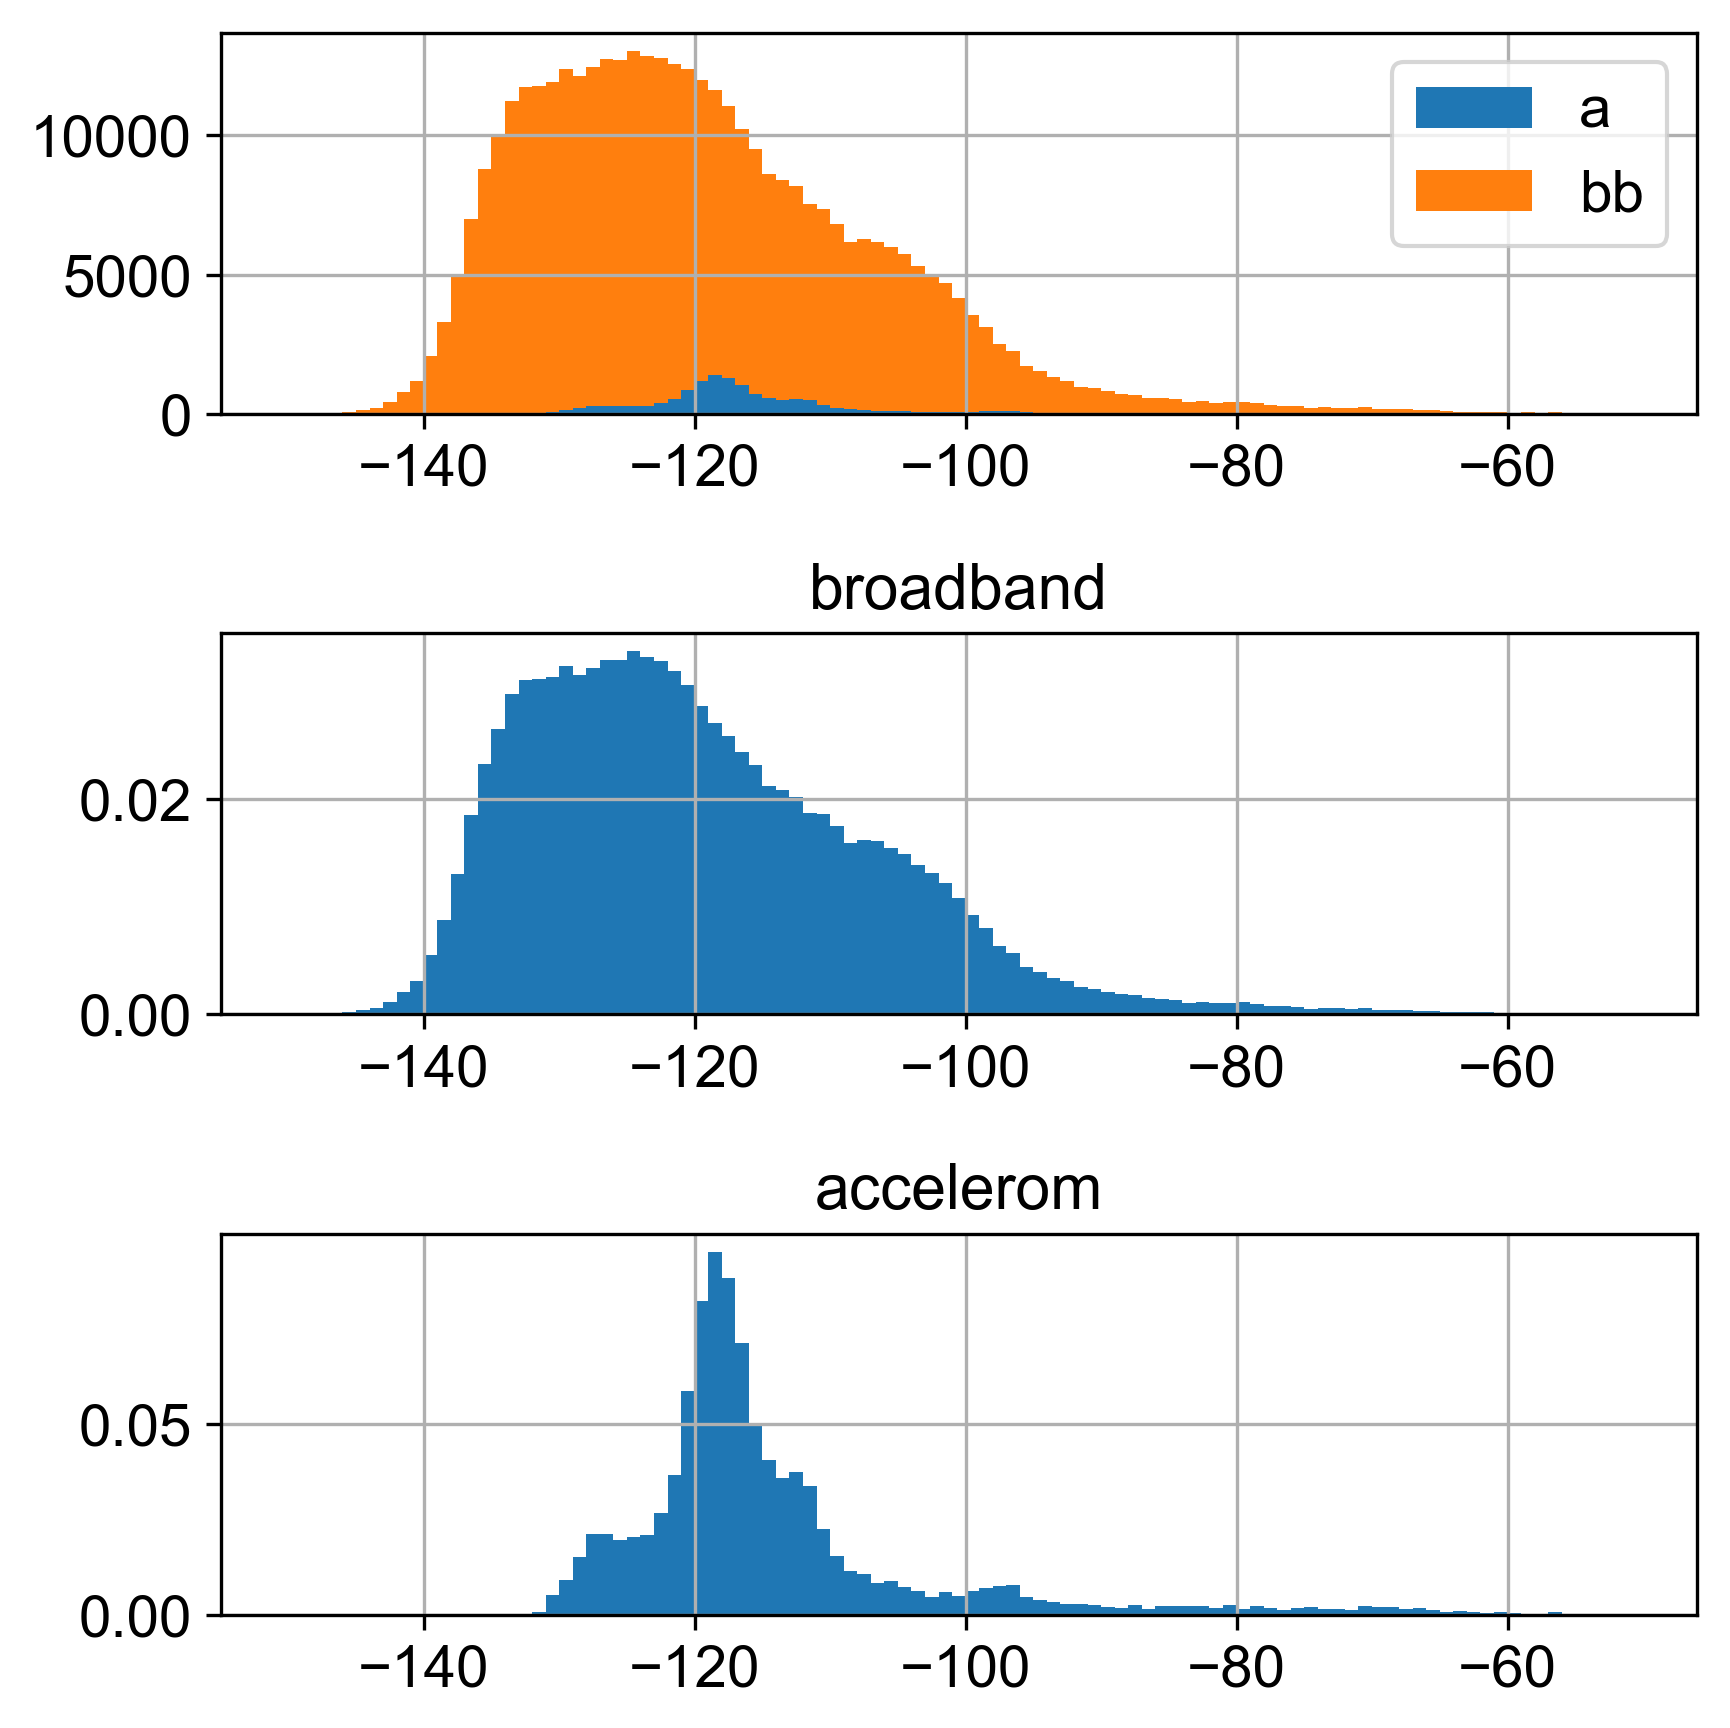

In [55]:
testdf_ = pd.read_hdf(os.path.join(rootpath, TRAINSET_U),
                    columns=['channel_code', 'psd@5sec', 'outlier'])
testdf_.channel_code = testdf_.channel_code.astype('category')
oldlen = len(testdf_)
testdf_ = testdf_[testdf_.channel_code.str.match('^(BH.|HH.|HL.|HN.|HG.)$')]
assert len(testdf_) < oldlen
print(pd.unique(testdf_.channel_code).tolist())
testdf_['accelerometer'] = True
flt = testdf_.channel_code.str.match('^(BH.|HH.)$')
assert flt.any() and not flt.all()
testdf_.loc[flt, 'accelerometer'] = False
assert testdf_.accelerometer.any() and not testdf_.accelerometer.all() 
_ = testdf_[~testdf_.outlier]

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['font.size'] = 14
bins = np.arange(-150, -50, 1)
# plt.hist(_[~_['accelerometer']]['psd@5sec'], bins=bins, label='bb', stacked=True, density=True)
# plt.hist(_[_['accelerometer']]['psd@5sec'], bins=bins, label='a', stacked=True, density=True)
fig, axes = plt.subplots(3, 1)
axes[0].hist([_[_['accelerometer']]['psd@5sec'],_[~_['accelerometer']]['psd@5sec']],
             bins=bins, label=['a', 'bb'], stacked=True)
axes[0].legend()
axes[0].grid()
axes[1].hist(_[~_['accelerometer']]['psd@5sec'], bins=bins, label='bb', stacked=True, density=True)
axes[1].set_title('broadband')
axes[1].grid()
axes[2].hist(_[_['accelerometer']]['psd@5sec'], bins=bins, label='a', stacked=True, density=True)
axes[2].set_title('accelerom')
axes[2].grid()
plt.tight_layout()

# plt.grid()
# plt.legend()
# plt.scatter(_['psd@5sec'], _['accelerometer'], alpha=0.1)
plt.show()
plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14

In [ ]:
printhtml('<h3>Plotting some segments and their predicted score in details</h3>')

nest = 100
maxs = 2048

# low and high ranges (in dB) of "undecided zone"
lpsd = [-152, -138]
hpsd = [-100, -66]
# ranges = [-152, -138], [-100, -66]

printhtml('<h4>Classifier used:</h4>')
eval_df3 = eval_df2[(eval_df2.n_estimators == nest) & (eval_df2.max_samples == maxs)]
display(eval_df3)
clf = load_clf(dirname(eval_df3.relative_filepath.iloc[0]) + '.sklmodel')
display(clf)
pred_df = read_pred_df(join(dirname(eval_df3.relative_filepath.iloc[0]), TESTSETNAME12), columns=None)

def ppsd_2(segment, inventory):
    periods, amplitudes_db = ppsd(seg.stream()[0], seg.inventory())
    _, amplitude_db_5 = ppsd(seg.stream()[0], seg.inventory(), 5)
    return periods, amplitudes_db, amplitude_db_5


def plot_trace(axs, trace, inventory=None, **kwargs):
    from obspy import UTCDateTime
    # time0, dt = trace.stats.starttime, trace.stats.delta
    # times = [(time0 + dt*i).datetime for i in range(len(trace))]
    # trace = trace.trim(None, trace.stats.starttime+60)
    if inventory is not None:
        trace = trace.copy().remove_response(inventory)
    axs.plot(trace, **kwargs)
    axs.set_xticks([0, len(trace)-1])
    stime = UTCDateTime(int(np.round(float(trace.stats.starttime))))
    etime = UTCDateTime(int(np.round(float(trace.stats.endtime))))
    # would be nice if the first tick displayed the date also, something as: stime.isoformat().replace('T', ' ')
    # but then labels take too much room. So:
    ticklabel1 = stime.isoformat()[stime.isoformat().find('T')+1:]
    ticklabel2 = etime.isoformat()[etime.isoformat().find('T')+1:]
    axs.set_xticklabels([ticklabel1, ticklabel2])
    axs.ticklabel_format(axis='y', style='sci', scilimits=(-0,0))
    # axs.grid()


PSD_YLIM = (-200, 75)


def plot_psd(axs, trace, inventory, **kwargs):
    periods, amplitudes_db, amplitude_db_5 = ppsd_2(trace, inventory)
    kwargs.setdefault('linewidth', 2)
    axs.semilogx(periods, amplitudes_db, **kwargs)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    axs.axvline(5, color=[0., 0., 0.], linewidth=6)
    axs.plot([5, 5], [lpsd[0], hpsd[1]], marker='None', color=[0.75, 0.75, 0.75], linewidth=6)
    axs.plot([5, 5], [lpsd[1], hpsd[0]], marker='None', color=[1, 1, 1], linewidth=6)
    
#     areacolor = [0.85, 0.85, 0.85]  # outlier zone in dark gray:
#     axs.set_facecolor(areacolor)
#     areacolor = [0.925, 0.925, 0.925]
#     axs.axhspan(lpsd[0], hpsd[1], alpha=1, zorder=-10, color=areacolor, fill=True)
#     areacolor = [1, 1, 1]
#     axs.axhspan(lpsd[1], hpsd[0], alpha=1, zorder=-10, color=areacolor, fill=True)
    
    
    # areacolor = [0.8, 0.8, 0.8]
    # axs.axhline(lpsd[1], linestyle='--', zorder=-5, color=areacolor)
    # axs.axhline(hpsd[0], linestyle='--', zorder=-5, color=areacolor)
    
    clf_score = -clf.score_samples([[amplitude_db_5]])
    color = kwargs.get('color', 'black')
    axs.scatter(5, amplitude_db_5, marker='o', label='score=%.2f' % clf_score,
                color='white', edgecolor=color, linewidth=2, zorder=100)
    axs.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', mode='expand')
    axs.set_ylim(*PSD_YLIM)
    #axs.grid()

fig = plt.figure(constrained_layout=True)
gsp = fig.add_gridspec(6, 4, width_ratios=[1, 10, 10, 10])
    
colors = get_colors(2, 0.35, 0.6)  # [::-1]

def plotall(segment, row_idx, caption, trace=None, inv=None):
    '''plots a row of plots'''
    if trace is None:
        trace = segment.stream()[0]
    if inv is None:
        inv = segment.inventory()
    # show the already computed scores for a double check:
    seg_pred_df = pred_df[(pred_df['Segment.db.id'] == seg.id) & (pred_df.dataset_id == dataset_id)]
    print()
    print('Segment to plot:')
    display(seg_pred_df)
    # get all channel segments and print median score:
    scores = pred_df[(pred_df.station_id == seg.channel.station_id) & (pred_df.dataset_id == dataset_id) &
                     (pred_df.location_code == seg.channel.location) & (pred_df.channel_code == seg.channel.channel)].predicted_anomaly_score
    print('%d segments of same channel found, median score: %.2f' % (len(scores), scores.median()))
    print()
    # assert labelling is correct (just a check):
    outliers_count = seg_pred_df.outlier.sum() 
    assert outliers_count in (0, len(seg_pred_df))
    kwargs = {'color': colors[bool(outliers_count)]}
    # plot stuff:
    axs0 = fig.add_subplot(gsp[row_idx, 0])
    axs0.text(0.5, 1, caption, ha='right', va='top', rotation=0, linespacing=2,
              fontsize=plt.rcParams['axes.titlesize'])  # , family='monospace') 
    axs0.set_axis_off()
    axs1 = fig.add_subplot(gsp[row_idx, 1])
    plot_trace(axs1, trace, **kwargs)
    axs2 = fig.add_subplot(gsp[row_idx, 2])
    plot_trace(axs2, trace, inv, **kwargs)
    axs3 = fig.add_subplot(gsp[row_idx, 3])
    plot_psd(axs3, trace, inv, **kwargs)
    # if row_idx == 0:
    #    axs1.set_title('Trace')
    #    axs2.set_title('Trace (resp. removed)')
    #    axs3.set_title('PSD')
    
    allaxes = axs1, axs2, axs3
    # don't know why, but the gird appears on the LASt psd (??!)
    # turn grid off for all axes (set to True to turn it on):
    for _ in allaxes:
        _.grid(False, which='major', axis='both', linewidth=0)
    return allaxes


plt.rcParams['figure.figsize'] = (14, 16)
plt.rcParams['font.size'] = 14


# filter for the db query (common to all):
flt = (Segment.has_data) & (Segment.maxgap_numsamples.between(-0.499, 0.499))

psd_axes = []
rowindex = -1

# good station, segment is an outlier
rowindex += 1
dataset_id = 1
sess = get_db_session(dataset_id)
try:
    # sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
    # seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = 21202165  # int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Segment artifact')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Scale_units = nm/sec
# they specify a good scale_units, but obspy's documentation asserts that they
# assume units in m/sec (FIXME: citation?!!)
rowindex += 1
dataset_id = 1
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SL' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Channel big scale\n(scale_units $\\dfrac{nm}{sec})$')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Scale is big,  but scale units is ok, most likely metadata error.
# We cannot say which is the cause, but the anomaly detector is good
# (we suspect some mistake in the inventory)
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.network == 'SJ' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    # in this case, display only noise otherwise it seems we
    # can classify only signals:
    tra = seg.stream()[0].copy().trim(None, seg.stream()[0].stats.starttime + 60)
    _ = plotall(seg, rowindex, 'Channel big scale\n(potential\nmetadata error)', trace=tra)  
    psd_axes.append(_[-1])
finally:
    sess.close()

    
# # Metadata stage gain error
# from obspy import read_inventory
# inv = read_inventory(join(dirname(dirname(os.get_cwd())), 'stream2segment', 'inventories',
#                           'CH.GRIMS.2015-10-30T10:50:00.xml'))
# rowindex += 1
# dataset_id = 1
# sess = get_db_session(dataset_id)
# try:
#     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
#     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
#     seg_ids = seg_ids['Segment.db.id'].tolist()
#     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2016, 1, 1)) & flt).limit(1).one()
#     _ = plotall(seg, rowindex, 'Metadata\nstage gain\nerror', inv=inv)
#     psd_axes.append(_[-1])
# finally:
#     sess.close()

    
# # Metadata stage gain error
# rowindex += 1
# dataset_id = 1
# sess = get_db_session(dataset_id)
# try:
#     sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'CH.GRIMS' ) & Station.has_inventory)]
#     seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
#     seg_ids = seg_ids['Segment.db.id'].tolist()
#     seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2018, 1, 1)) & flt).limit(1).one()
#     _ = plotall(seg, rowindex, 'Stage gain\nerror fixed')
#     psd_axes.append(_[-1])
# finally:
#     sess.close()

    
# Broken sensor:
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_ids = seg_ids['Segment.db.id'].tolist()
    seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time < datetime(2019, 1, 1)) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Broken sensor')
    psd_axes.append(_[-1])
finally:
    sess.close()

# Broken sensor repaired (same channel as above):
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'NU.MGAN' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_ids = seg_ids['Segment.db.id'].tolist()
    seg = sess.query(Segment).join(Segment.event).filter(Segment.id.in_(seg_ids) & (Event.time > datetime(2019, 6, 1)) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Repaired sensor')
    psd_axes.append(_[-1])
finally:
    sess.close()


# Low channel noise
rowindex += 1
dataset_id = 2
sess = get_db_session(dataset_id)
try:
    sta_ids = [_[0] for _ in sess.query(Station.id).filter((Station.netsta_code == 'IS.GEM' ) & Station.has_inventory)]
    seg_ids = pred_df[pred_df.station_id.isin(sta_ids)]
    seg_id = int(seg_ids.iloc[0]['Segment.db.id'])
    seg = sess.query(Segment).filter((Segment.id == seg_id) & flt).limit(1).one()
    _ = plotall(seg, rowindex, 'Channel low\nnoise level')
    psd_axes.append(_[-1])
finally:
    sess.close()

# for _ in psd_axes:
#    _.set_ylim(-200, 50)
# samey(psd_axes)

savefig(fig, 'interesting_segments_detailed_scores')
plt.grid()
plt.show()


plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15

Plotting some segments and their predicted score in details

Classifier used:

clf     feats  n_estimators  max_samples  random_state  \
5040  IsolationForest  psd@5sec           100         2048            11   

      roc_auc_score  average_precision_score  log_loss  best_th_pr_curve  \
5040       0.974035                 0.970464  0.610812          0.756818   

     behaviour  best_th_roc_curve contamination  \
5040       new           0.750291          auto   

                                                                                                                                                                                    relative_filepath  \
5040  clf=IsolationForest&tr_set=allset_train.hdf&feats=psd@5sec&behaviour=new&contamination=auto&max_samples=2048&n_estimators=100&random_state=11/allset_test_AND_allset_unlabelled_annotation2.hdf   

                tr_set  
5040  allset_train.hdf

IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=2048, n_estimators=100,
                n_jobs=None, random_state=11, verbose=0, warm_start=False)


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
699493       21202165           1        4451          HNZ                 
699494       21202165           1        4451          HNZ                 

        window_type          event_time  hand_labelled  outlier  \
699493        False 2016-12-06 08:46:56           True     True   
699494         True 2016-12-06 08:46:56           True     True   

        predicted_anomaly_score  
699493                 0.650882  
699494                 0.851931

2154 segments of same channel found, median score: 0.64


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
714098       17878897           1        7744          HHE                 
714099       17878897           1        7744          HHE                 

        window_type          event_time  hand_labelled  outlier  \
714098        False 2016-10-26 21:52:52           True     True   
714099         True 2016-10-26 21:52:52           True     True   

        predicted_anomaly_score  
714098                 0.716124  
714099                 0.703147

1188 segments of same channel found, median score: 0.68


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
837566            828           2        1070          BHZ                 
837567            828           2        1070          BHZ                 

        window_type          event_time  hand_labelled  outlier  \
837566        False 2019-08-29 15:07:59           True     True   
837567         True 2019-08-29 15:07:59           True     True   

        predicted_anomaly_score  
837566                 0.851931  
837567                 0.851931

5968 segments of same channel found, median score: 0.85


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
775824         426081           2        1061          BHZ                 
775825         426081           2        1061          BHZ                 

        window_type          event_time  hand_labelled  outlier  \
775824        False 2018-08-17 04:35:27           True     True   
775825         True 2018-08-17 04:35:27           True     True   

        predicted_anomaly_score  
775824                 0.833280  
775825                 0.834483

3572 segments of same channel found, median score: 0.83


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
690929          10673           2        1061          BHZ                 
690930          10673           2        1061          BHZ                 

        window_type          event_time  hand_labelled  outlier  \
690929        False 2019-08-10 03:41:21           True    False   
690930         True 2019-08-10 03:41:21           True    False   

        predicted_anomaly_score  
690929                 0.423876  
690930                 0.428870

3572 segments of same channel found, median score: 0.83


Segment to plot:


Segment.db.id  dataset_id  station_id channel_code location_code  \
646287           2058           2        1010          BHZ                 
646288           2058           2        1010          BHZ                 

        window_type          event_time  hand_labelled  outlier  \
646287        False 2019-08-28 23:46:40           True    False   
646288         True 2019-08-28 23:46:40           True    False   

        predicted_anomaly_score  
646287                 0.778989  
646288                 0.746974

3292 segments of same channel found, median score: 0.77



Saving figure to "~/Nextcloud/rizac/outliers_paper/paper_figures/interesting_segments_detailed_scores.png"

In [10]:
# robustness wrt gain change in the response
# create an array of 100 "good" psd periods (see figure above)
psds = np.random.uniform(lpsd[1],hpsd[0], [1000,1]) # A 2x3 array
scores = -clf.score_samples(psds)
cc = (scores <= 0.5).sum() / float(len(scores))
printhtml(f'<h4>CC instances (<=0.5): {cc:.2f}</h4>')
data = {'Resp. multiplication factor': [], 'Correctly classified ratio': []}
for factor in [0.001, 0.01, 0.1, 1, 10, 100, 150, 1000]:
    # factor = 10.0 ** N
    if factor == 1:
        cc_ = cc
    else:
        psds_ = np.copy(psds) - 10 * np.log10(factor ** 2)
        scores_ = -clf.score_samples(psds_)
        cc_ = (scores_ > 0.75).sum() / float(len(scores_))
    data['Resp. multiplication factor'].append(factor)
    data['Correctly classified ratio'].append(cc_)

display(pd.DataFrame(data))

CC instances (<=0.5): 0.95

Resp. multiplication factor  Correctly classified ratio
0                        0.001                       0.759
1                        0.010                       0.242
2                        0.100                       0.000
3                        1.000                       0.950
4                       10.000                       0.167
5                      100.000                       0.679
6                      150.000                       0.774
7                     1000.000                       1.000